<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/connectivity_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
conn_measures = ['PAC', 'PEC', 'SC_R(1,4)', 'SC_I(1,4)', 'PLV(1,4)', 'PLI(1,4)', 'CC(1,4)', 'SC_R(4,8)', 'SC_I(4,8)', 'PLV(4,8)', 'PLI(4,8)', 'CC(4,8)', 'SC_R(8,12)', 'SC_I(8,12)', 'PLV(8,12)', 'PLI(8,12)', 'CC(8,12)', 'SC_R(13,30)', 'SC_I(13,30)', 'PLV(13,30)', 'PLI(13,30)', 'CC(13,30)', 'SC_R(30,70)', 'SC_I(30,70)', 'PLV(30,70)', 'PLI(30,70)', 'CC(30,70)', 'SC_R(70,150)', 'SC_I(70,150)', 'PLV(70,150)', 'PLI(70,150)', 'CC(70,150)']

In [3]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
# cm_subs = {
#     "SC_R": "Real spectral coherence",
#     "SC_I": "Imaginary spectral coherence",
#     "PLV": "Phase-locking value",
#     "PLI": "Phase lag index",
#     "CC": "Cross-correlation",
#     "PAC": "PAC",
#     "PEC": "PEC"
# }
cm_subs = {
    "SC_R": "SCR",
    "SC_I": "SCI",
    "PLV": "PLV",
    "PLI": "PLI",
    "CC": "CC",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC(30,70), SC_R(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print(output_str)


CC (low γ), SCR (high γ)


Single connectivity measures:

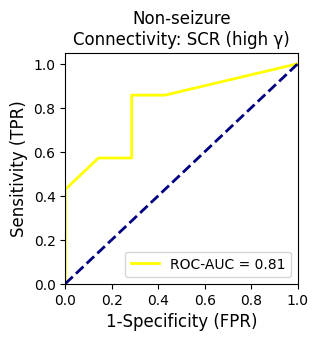

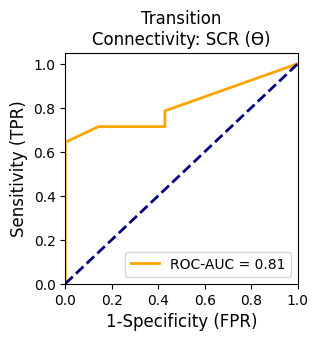

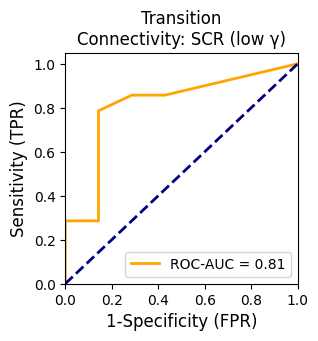

In [5]:
# List to store results
results = []

# Define the mapping for WOI and colors
woi_dict = {
    "NN": {"label": "Non-seizure", "color": "yellow"},
    "N60S": {"label": "Pre-seizure", "color": "gold"},
    "NS": {"label": "Transition", "color": "orange"},
    "NE": {"label": "Seizure", "color": "red"}
}

# Loop through the time frames
for woi in ["NN", "N60S", "NS", "NE"]:
    # Load the appropriate data file
    file_name = main_folder + "results.xlsx"
    if woi == "NN":
        file_name = main_folder + "results-nn.xlsx"
    load_data = pd.read_excel(file_name, engine='openpyxl')

    # Filter the data by the current time frame
    load_data = load_data[load_data['time_frame'] == woi]

    # Loop through each connectivity measure
    for cm in conn_measures:
        # Group the data by method and get the group for the current connectivity measure
        data = load_data.groupby("method").get_group(cm)
        scores, actual_labels = list(data.score1), list(data.outcome)

        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(actual_labels, scores)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Compute Youden's index
        youden_index = tpr - fpr
        best_threshold_index = np.argmax(youden_index)

        # Sensitivity and specificity at the best threshold
        sens = tpr[best_threshold_index]
        spec = 1 - fpr[best_threshold_index]

        # Append the results to the list
        results.append({
            'WOI': woi,
            'CM': cm,
            'AUC': roc_auc,
            'Sensitivity': sens,
            'Specificity': spec
        })

        # Plot the ROC curve if AUC > 0.8
        if roc_auc > 0.8:
            woi_str = woi_dict[woi]["label"]
            color = woi_dict[woi]["color"]
            cm_str = substitute_cm(cm)
            cm_str = substitute_bands(cm_str)

            plt.figure(figsize=(3, 3))
            plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (FPR)', size=12)
            plt.ylabel('Sensitivity (TPR)', size=12)
            plt.title(f'{woi_str}\nConnectivity: {cm_str}')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
# results_df.to_excel(main_folder + "1cm_rocauc_results.xlsx", index=False)


Visualize the distribution of ROC AUC scores for connectivity measures across different time intervals and identify the measures that score the best and those that score randomly (close to 0.5).

In [30]:
sorted_cm_list = [
    'PAC',
    'PEC',
    'CC(1,4)',
    'CC(4,8)',
    'CC(8,12)',
    'CC(13,30)',
    'CC(30,70)',
    'CC(70,150)',
    'PLI(1,4)',
    'PLI(4,8)',
    'PLI(8,12)',
    'PLI(13,30)',
    'PLI(30,70)',
    'PLI(70,150)',
    'PLV(1,4)',
    'PLV(4,8)',
    'PLV(8,12)',
    'PLV(13,30)',
    'PLV(30,70)',
    'PLV(70,150)',
    'SC_I(1,4)',
    'SC_I(4,8)',
    'SC_I(8,12)',
    'SC_I(13,30)',
    'SC_I(30,70)',
    'SC_I(70,150)',
    'SC_R(1,4)',
    'SC_R(4,8)',
    'SC_R(8,12)',
    'SC_R(13,30)',
    'SC_R(30,70)',
    'SC_R(70,150)']

<ipython-input-109-23146fd7d212>:62: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.swarmplot(data=results_df[results_df['Marker'] == marker],
<ipython-input-109-23146fd7d212>:62: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.swarmplot(data=results_df[results_df['Marker'] == marker],


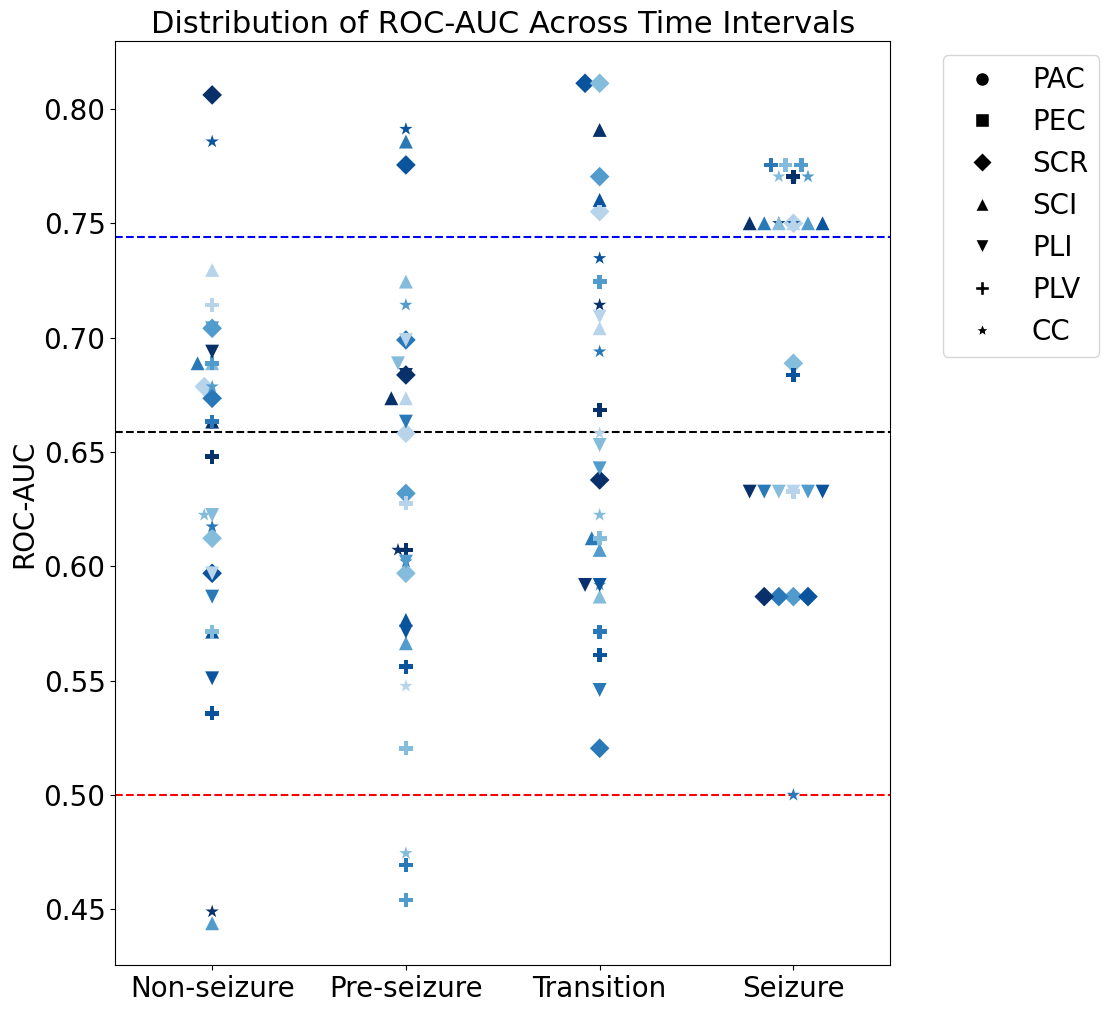

Best Connectivity Measures in Each Time Interval (WOI):
            WOI            CM       AUC
0    Transition   SCR (low γ)  0.811224
2   Non-seizure  SCR (high γ)  0.806122
3   Pre-seizure    CC (low γ)  0.791209
8       Seizure       PLV (ϴ)  0.775510
9       Seizure       PLV (α)  0.775510
10      Seizure       PLV (β)  0.775510
Connectivity Measures Scoring Randomly:
             WOI           CM       AUC
116  Pre-seizure       CC (δ)  0.547619
117   Transition      PLI (β)  0.545918
118  Non-seizure  PLV (low γ)  0.535714
119  Pre-seizure          PAC  0.525510
120  Pre-seizure      PLV (ϴ)  0.520408
121   Transition      SCR (β)  0.520408
122      Seizure       CC (β)  0.500000
123  Pre-seizure       CC (ϴ)  0.474490
124  Pre-seizure      PLV (β)  0.469388
125  Pre-seizure      PLV (α)  0.454082
126  Non-seizure  CC (high γ)  0.448980
127  Non-seizure      SCI (α)  0.443878


In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define the frequency bands and corresponding shades of blue
freq_bands = ['δ', 'ϴ', 'α', 'β', 'low γ', 'high γ']
colors = plt.cm.Blues(np.linspace(0.3, 1, len(freq_bands)))  # Shades of blue from light to dark

# Create a dictionary mapping frequency bands to colors
freq_band_colors = dict(zip(freq_bands, colors))

# Define the mappings for CM labels to marker styles
cm_markers = {
    'PAC': 'o',       # Circle
    'PEC': 's',       # Square
    'SCR': 'D',       # Diamond
    'SCI': '^',       # Triangle up
    'PLI': 'v',       # Triangle down
    'PLV': 'P',       # Plus (filled)
    'CC': '*',        # Star
}

# Load the results dataframe (replace with your actual file path)
results_df = pd.read_excel(main_folder + "1cm_rocauc_results.xlsx", engine='openpyxl')

# Update WOI and CM labels
results_df['WOI'] = results_df['WOI'].map(lambda x: woi_dict[x]['label'])
results_df['CM'] = results_df['CM'].map(lambda x: substitute_cm(substitute_bands(x)))

# Extract frequency bands from CM labels and map to colors
results_df['Frequency Band'] = results_df['CM'].str.extract(r'\((.*?)\)', expand=False)
results_df['Color'] = results_df['Frequency Band'].map(freq_band_colors)

# Map CM labels to marker styles
results_df['Marker'] = results_df['CM'].map(lambda cm: cm_markers.get(cm.split('(')[0].strip(), 'o'))

# Define the order of WOI
woi_order = ['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure']

# Convert 'WOI' to categorical with specified order
results_df['WOI'] = pd.Categorical(results_df['WOI'], categories=woi_order, ordered=True)

# Random threshold
random_threshold = 0.5

# Calculate mean and standard deviations of AUC values
mean_auc = results_df['AUC'].mean()
std_auc = results_df['AUC'].std()

# Define thresholds for significant performance
one_std = mean_auc + std_auc
two_std = mean_auc + 2 * std_auc
three_std = mean_auc + 3 * std_auc

# Create scatter plots for the distribution of ROC AUC for each connectivity measure across time intervals
plt.figure(figsize=(10, 12))

# Plot each point with the corresponding color and marker
for marker in results_df['Marker'].unique():
    sns.swarmplot(data=results_df[results_df['Marker'] == marker],
                    x='WOI', y='AUC', hue='Frequency Band',
                    palette=freq_band_colors, marker=marker, s=10, legend=None)

plt.axhline(random_threshold, color='red', linestyle='--', label='Random Performance (ROC-AUC = 0.5)')
plt.axhline(mean_auc, color='black', linestyle='--', label=f'Mean (ROC-AUC = {mean_auc:.2f})')
plt.axhline(one_std, color='blue', linestyle='--', label=f'Mean + 1σ (ROC-AUC = {one_std:.2f})')
# plt.axhline(two_std, color='green', linestyle='--', label=f'2 STD above mean (AUC = {two_std:.2f})')
# plt.axhline(three_std, color='purple', linestyle='--', label=f'3 STD above mean (AUC = {three_std:.2f})')
plt.title('Distribution of ROC-AUC Across Time Intervals', size=22)
plt.xlabel('')
plt.ylabel('ROC-AUC', size=20)
plt.xticks(size=20)
plt.yticks(size=20)

# Identify the measures that score the best in each time interval
max_auc_per_woi = results_df.groupby('WOI')['AUC'].transform(max)
best_measures = results_df[results_df['AUC'] == max_auc_per_woi]

# # Add text labels for the best measures
# for idx, row in results_df.iterrows():
#     if row['AUC'] == max_auc_per_woi[idx]:
#         plt.text(row['WOI'], row['AUC'], f" {row['CM']}",
#                  color='black', ha='center', va='center', fontsize=12, zorder=5)

# Create a custom legend for the markers
handles, labels = [], []
for cm, marker in cm_markers.items():
    handles.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10))
    labels.append(cm)
plt.legend(handles, labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)

plt.show()

print("Best Connectivity Measures in Each Time Interval (WOI):")
print(best_measures[['WOI', 'CM', 'AUC']])

# Identify the measures that score randomly (close to 0.5)
random_measures = results_df[results_df['AUC'] <= random_threshold + 0.05]

print("Connectivity Measures Scoring Randomly:")
print(random_measures[['WOI', 'CM', 'AUC']])


<ipython-input-108-d14979860312>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.arange(len(freq_bands)), boundaries=np.arange(-0.5, len(freq_bands)))


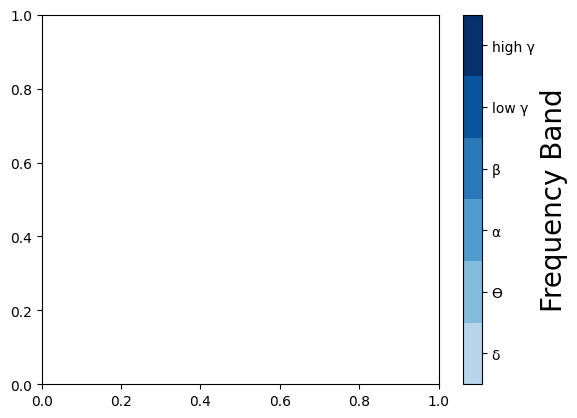

In [108]:
# Add a colorbar for the frequency bands
sm = plt.cm.ScalarMappable(cmap=ListedColormap(colors), norm=plt.Normalize(vmin=0, vmax=len(freq_bands)-1))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.arange(len(freq_bands)), boundaries=np.arange(-0.5, len(freq_bands)))
cbar.ax.set_yticklabels(freq_bands)
cbar.set_label('Frequency Band', size=20)


Combinations od 2 connectivity measures:

In [ ]:
# Function to compute AUC, sensitivity, and specificity for a given combination of connectivity measures
def compute_metrics_for_combination(cm_combination, load_data):

    combined_scores = []
    actual_labels = None

    for cm in cm_combination:

        data = load_data[load_data['method'] == cm]
        if data['score1'].values.shape[0] == 21:
          if actual_labels is None:
              actual_labels = data['outcome'].values
          combined_scores.append(data['score1'].values)
        else: break

    if len(combined_scores) == len(cm_combination):

      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      roc_auc = auc(fpr, tpr)

      # Compute Youden's index
      youden_index = tpr - fpr
      best_threshold_index = np.argmax(youden_index)

      # Sensitivity and specificity at the best threshold
      sens = tpr[best_threshold_index]
      spec = 1 - fpr[best_threshold_index]

      return roc_auc, sens, spec

    else: return None, None, None

WOI: NN


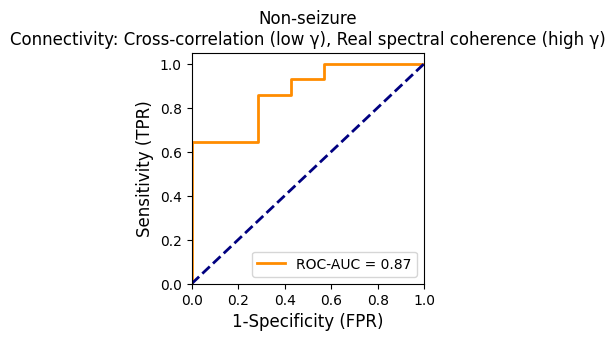

WOI: NS


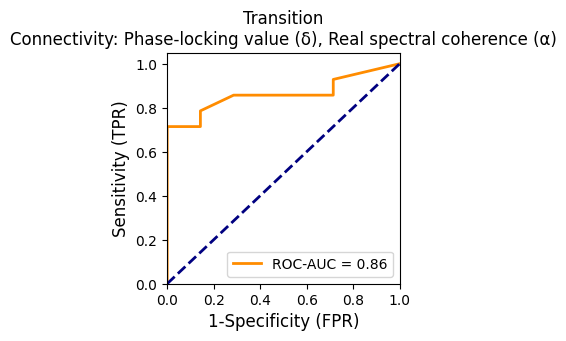

WOI: NS


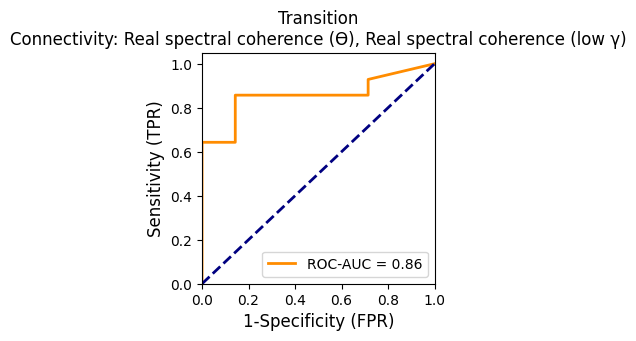

WOI: NS


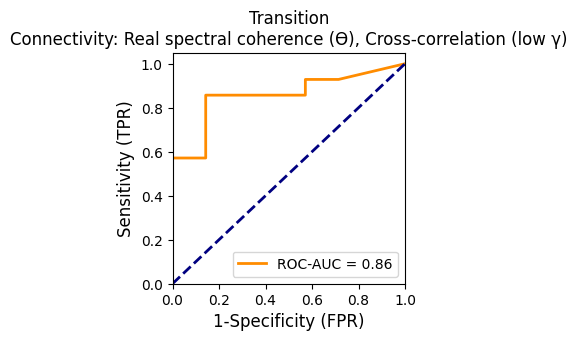

In [ ]:
# Generate combinations of 2 connectivity measures

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 2):

        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          combination_str = ', '.join(cm_combination)
          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve

          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.85:

            woi_str = ''
            if woi=="NS": woi_str = "Transition"
            elif woi=="N60S": woi_str = "Pre-seizure"
            elif woi=="NE": woi_str = "Seizure"
            elif woi=="NN": woi_str = "Non-seizure"

            cm_str = substitute_cm(combination_str)
            cm_str = substitute_bands(cm_str)

            plt.figure(figsize=(3,3))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (FPR)', size=12)
            plt.ylabel('Sensitivity (TPR)', size=12)
            plt.title(f'{woi_str}\nConnectivity: {cm_str}')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
# results_df.to_excel(main_folder + "2cm_rocauc_results.xlsx", index=False)

Combinations of 3 connectivity measures:

In [ ]:
# Generate combinations of 3 connectivity measures

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 3):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.9:

            woi_str = ''
            if woi=="NS": woi_str = "Transition"
            elif woi=="N60S": woi_str = "Pre-seizure"
            elif woi=="NE": woi_str = "Seizure"
            elif woi=="NN": woi_str = "Non-seizure"

            cm_str = substitute_cm(combination_str)
            cm_str = substitute_bands(cm_str)

            plt.figure(figsize=(3,3))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (FPR)', size=12)
            plt.ylabel('Sensitivity (TPR)', size=12)
            plt.title(f'{woi_str}\nConnectivity: {cm_str}')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "3cm_rocauc_results.xlsx", index=False)

<ipython-input-25-1cd47e57083e>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Combinations of 4 connectivity measures:

The AUC is: 0.8571428571428571, Sensitivity: 0.7857142857142857, Specificity: 0.8571428571428572


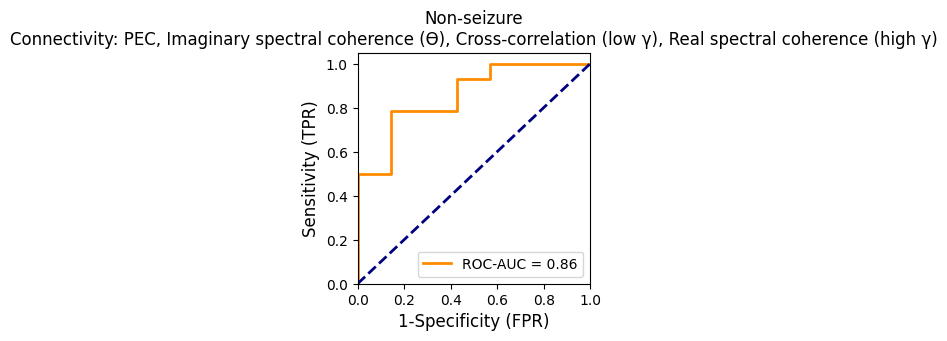

The AUC is: 0.8571428571428571, Sensitivity: 0.7142857142857143, Specificity: 1.0


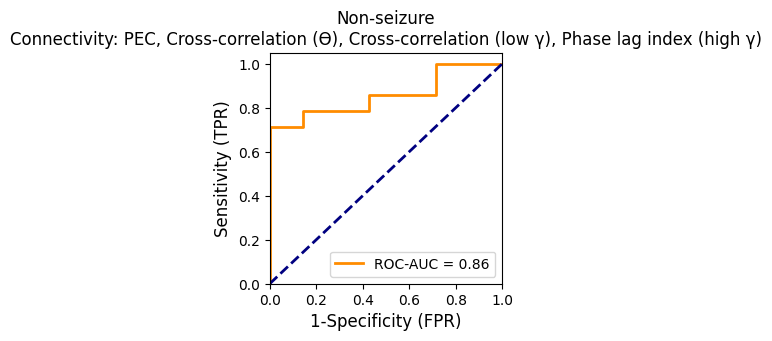

The AUC is: 0.8673469387755103, Sensitivity: 0.6428571428571429, Specificity: 1.0


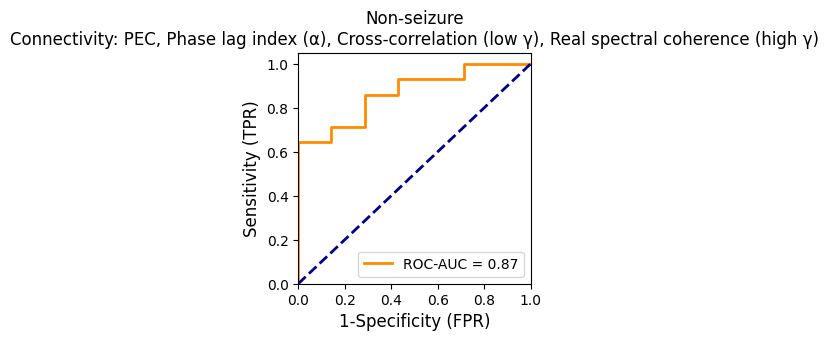

The AUC is: 0.8775510204081634, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


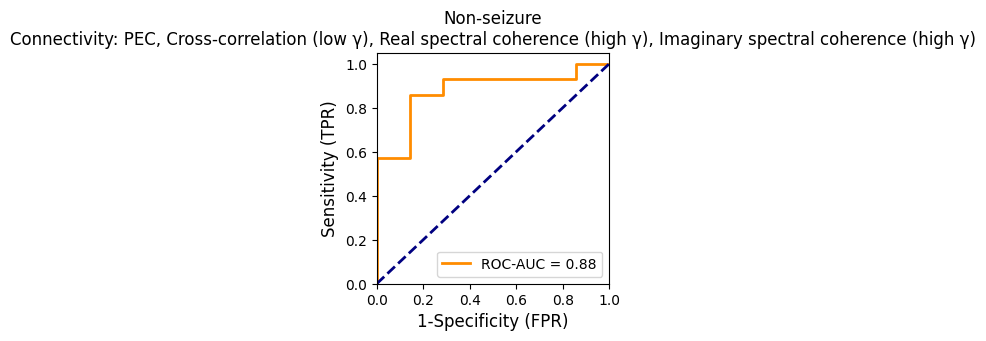

The AUC is: 0.8622448979591837, Sensitivity: 0.6428571428571429, Specificity: 1.0


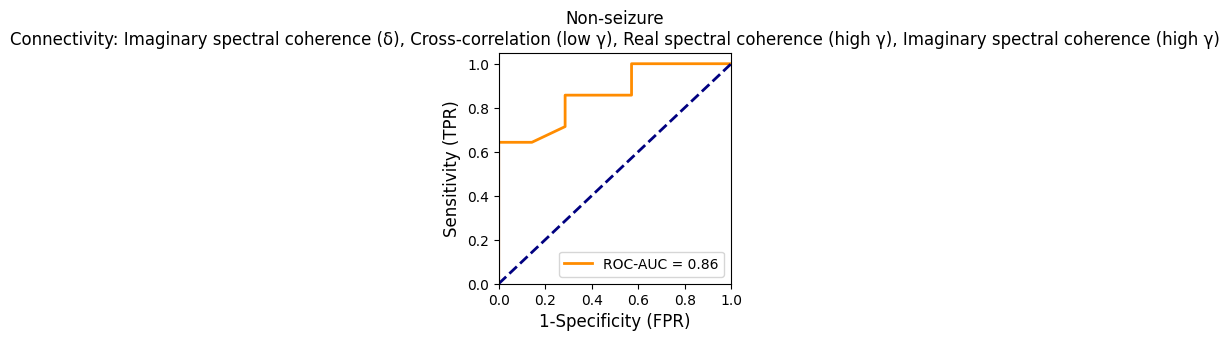

The AUC is: 0.8571428571428572, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


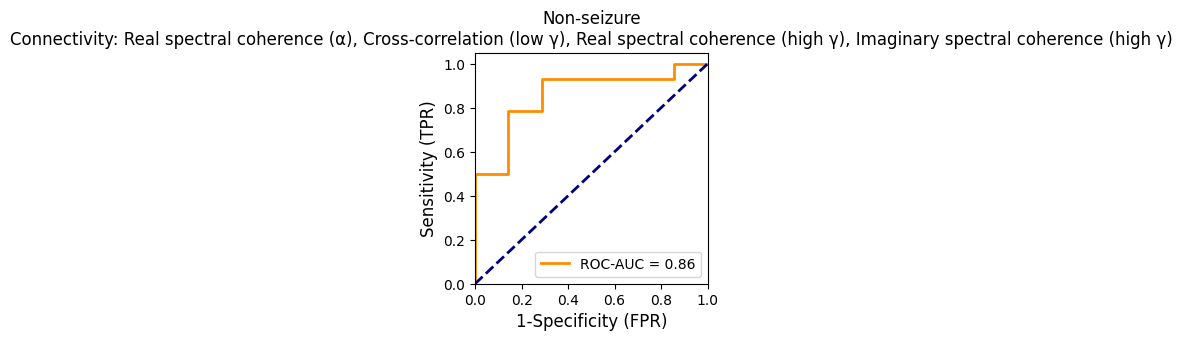

The AUC is: 0.8520408163265305, Sensitivity: 0.7142857142857143, Specificity: 1.0


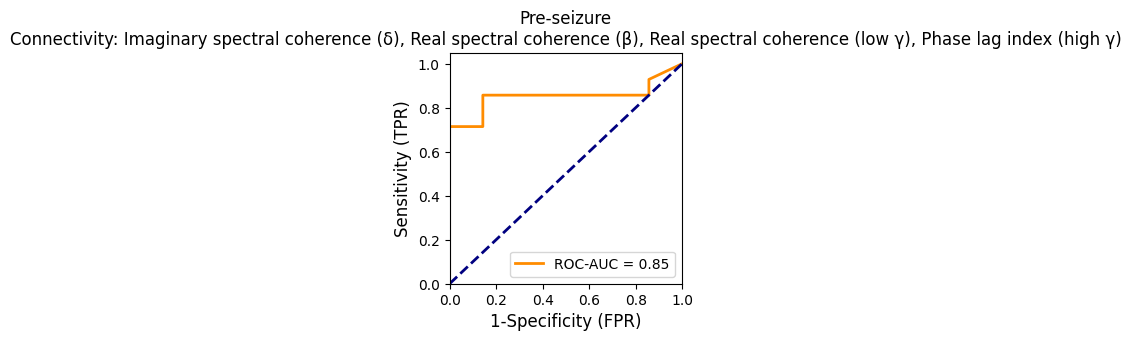

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


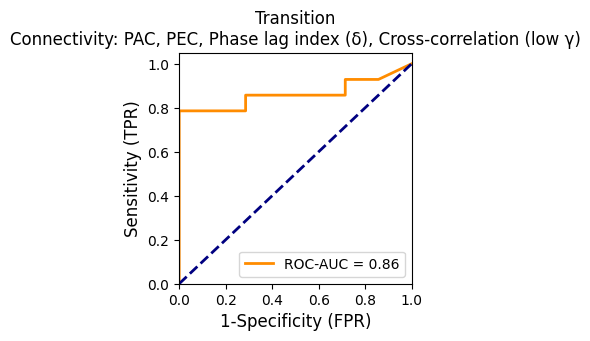

The AUC is: 0.8571428571428572, Sensitivity: 0.7142857142857143, Specificity: 1.0


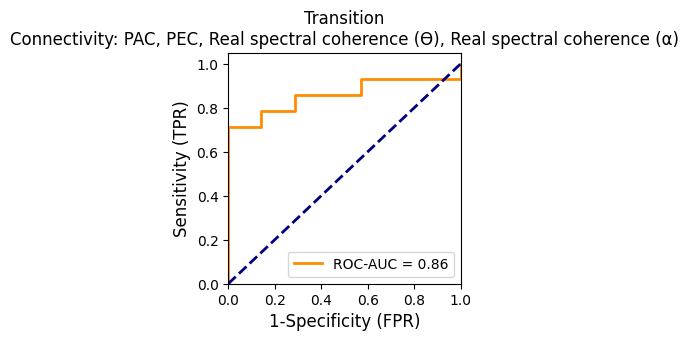

The AUC is: 0.8571428571428572, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


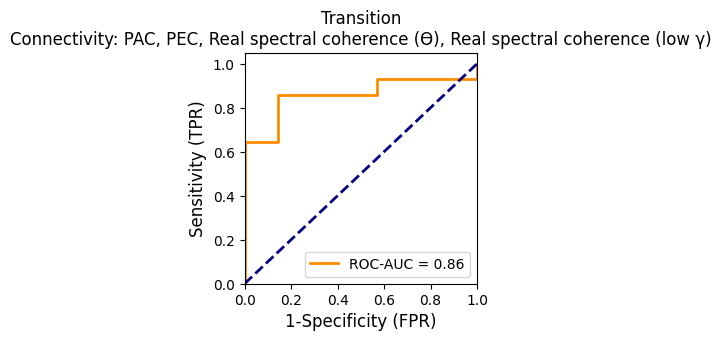

The AUC is: 0.8571428571428572, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


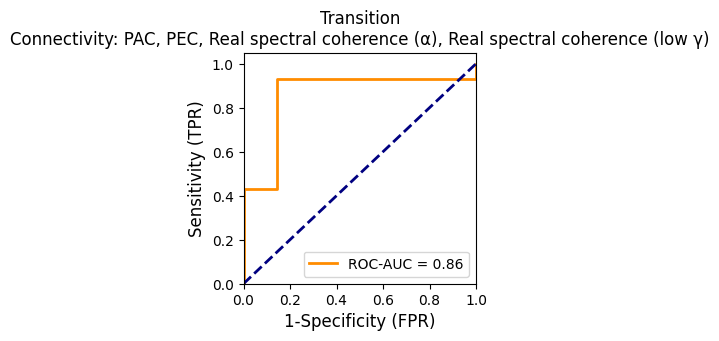

The AUC is: 0.8571428571428571, Sensitivity: 0.7142857142857143, Specificity: 1.0


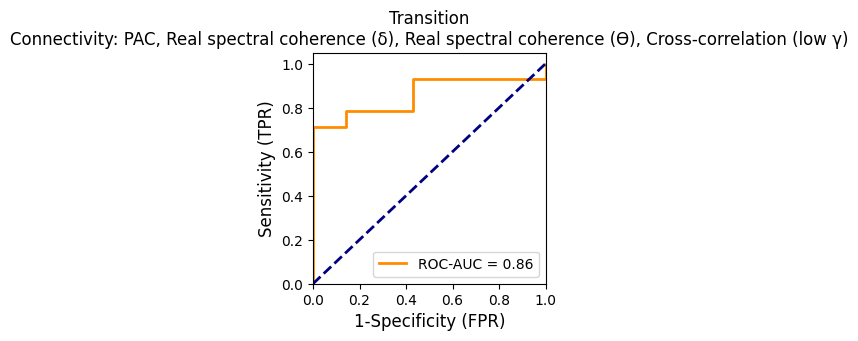

The AUC is: 0.8520408163265305, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


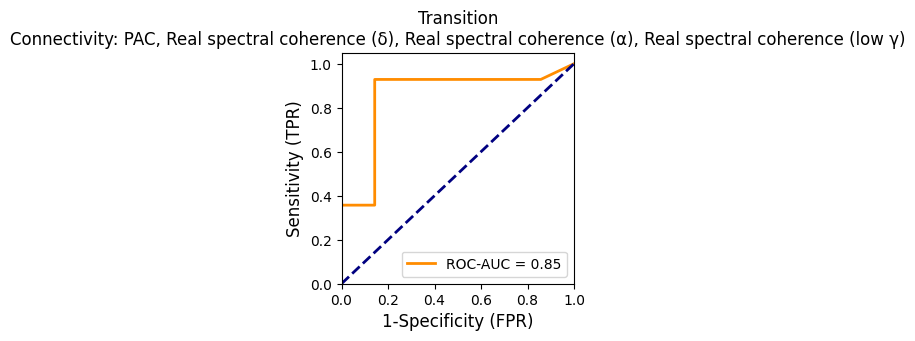

The AUC is: 0.8520408163265305, Sensitivity: 0.7142857142857143, Specificity: 1.0


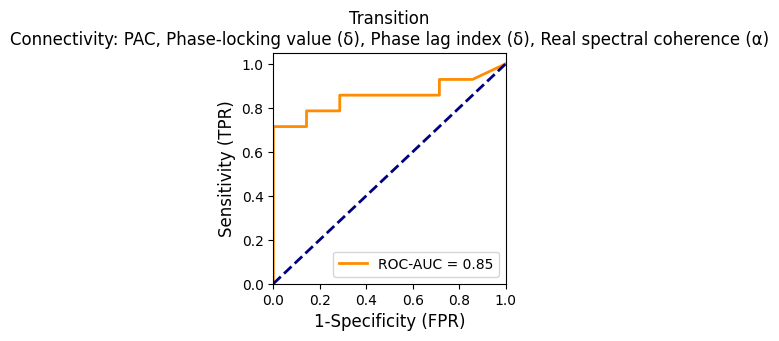

The AUC is: 0.8673469387755102, Sensitivity: 0.7857142857142857, Specificity: 1.0


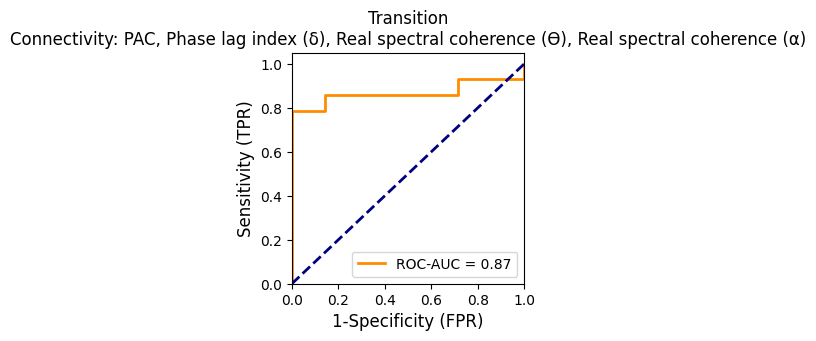

The AUC is: 0.8571428571428571, Sensitivity: 0.7142857142857143, Specificity: 1.0


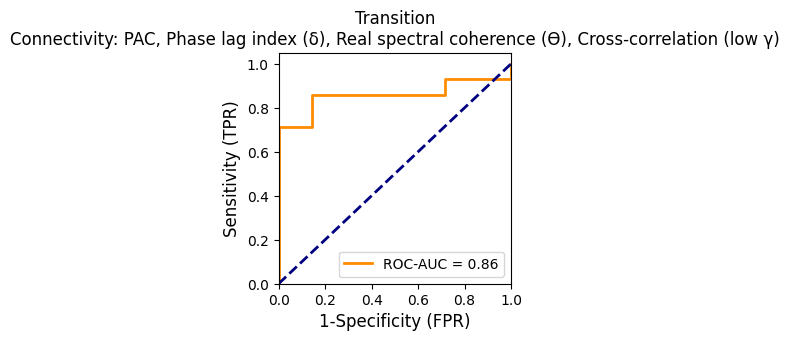

The AUC is: 0.8775510204081634, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


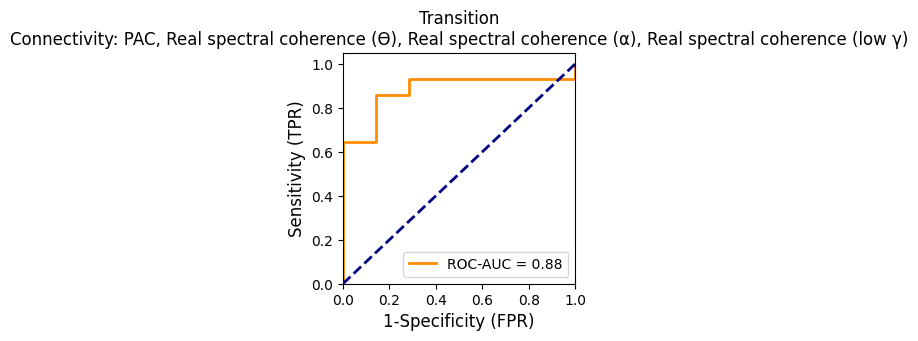

The AUC is: 0.8673469387755103, Sensitivity: 0.7142857142857143, Specificity: 1.0


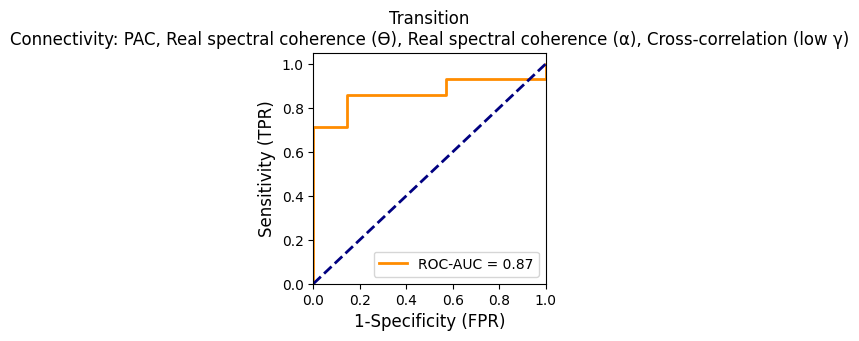

The AUC is: 0.8571428571428572, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


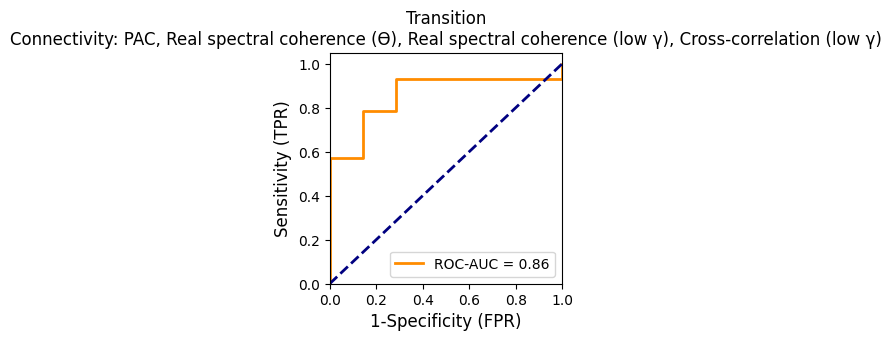

The AUC is: 0.8571428571428572, Sensitivity: 0.6428571428571429, Specificity: 1.0


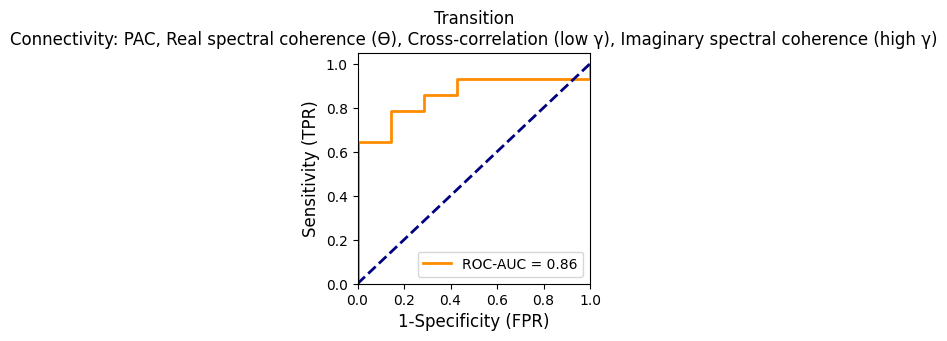

The AUC is: 0.8520408163265307, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


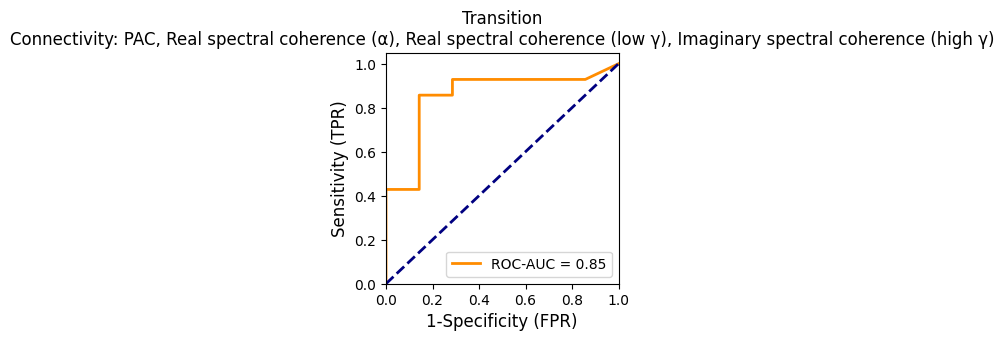

The AUC is: 0.8520408163265305, Sensitivity: 0.7857142857142857, Specificity: 1.0


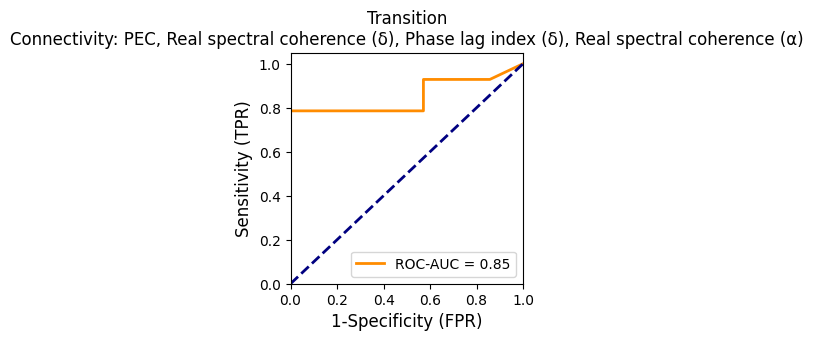

The AUC is: 0.8520408163265307, Sensitivity: 0.7857142857142857, Specificity: 1.0


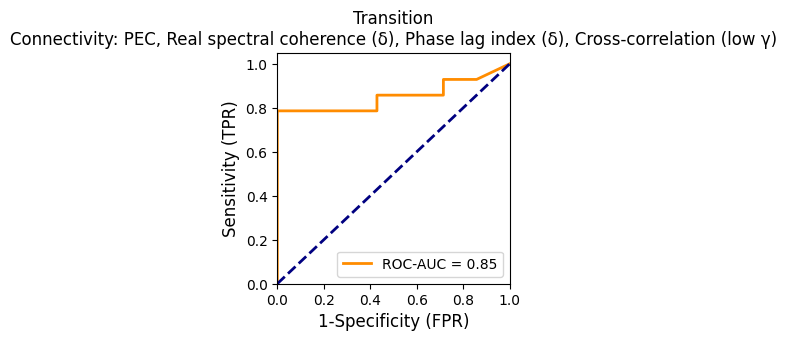

The AUC is: 0.8826530612244898, Sensitivity: 0.7857142857142857, Specificity: 1.0


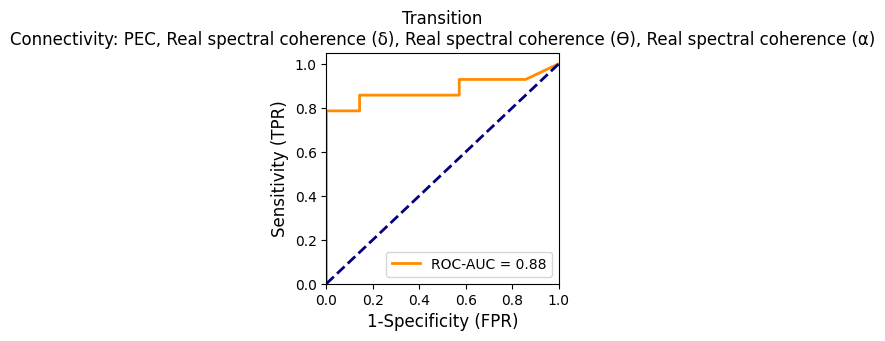

The AUC is: 0.8724489795918366, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


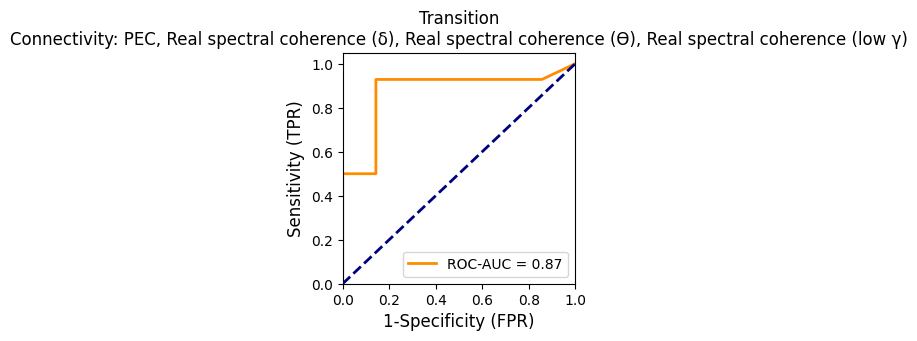

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


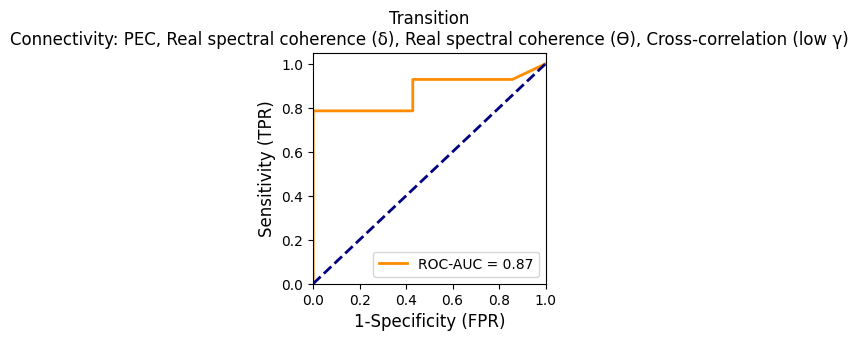

The AUC is: 0.8622448979591837, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


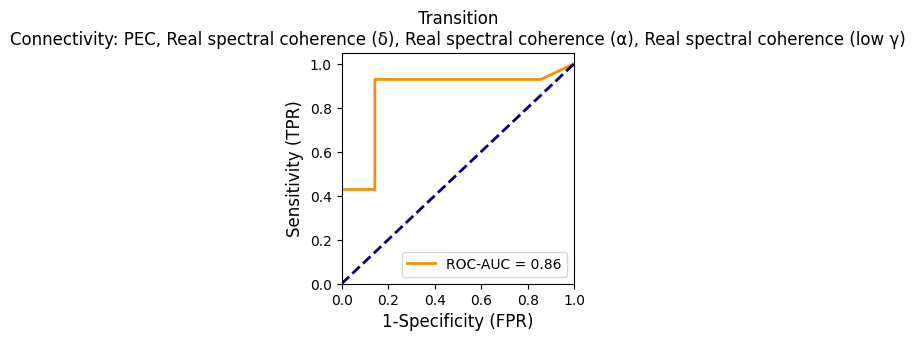

The AUC is: 0.8520408163265307, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


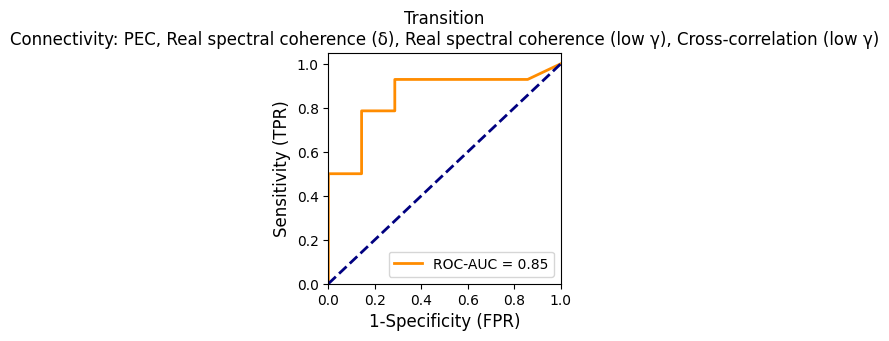

The AUC is: 0.8724489795918369, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


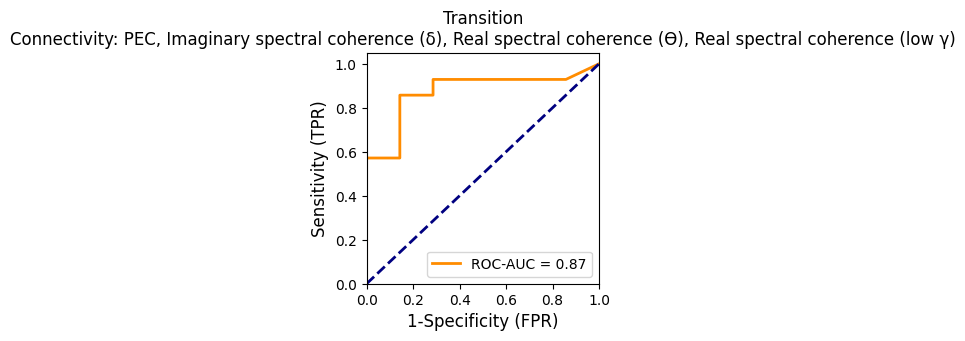

The AUC is: 0.8622448979591838, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


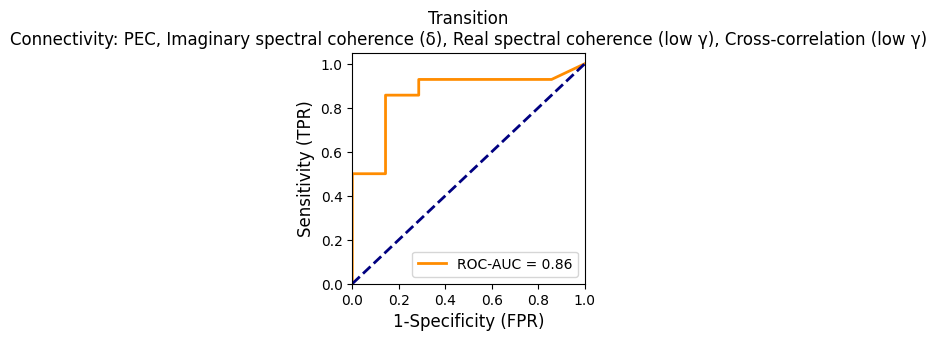

The AUC is: 0.8673469387755102, Sensitivity: 0.7857142857142857, Specificity: 1.0


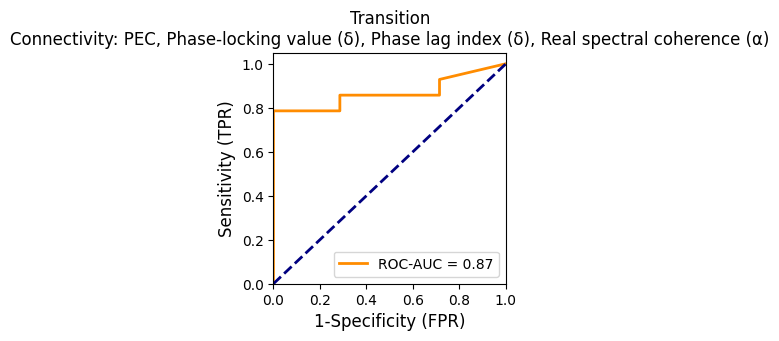

The AUC is: 0.8520408163265307, Sensitivity: 0.6428571428571429, Specificity: 1.0


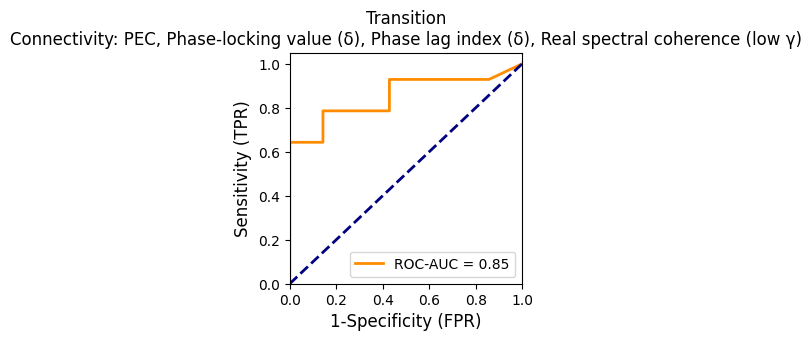

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


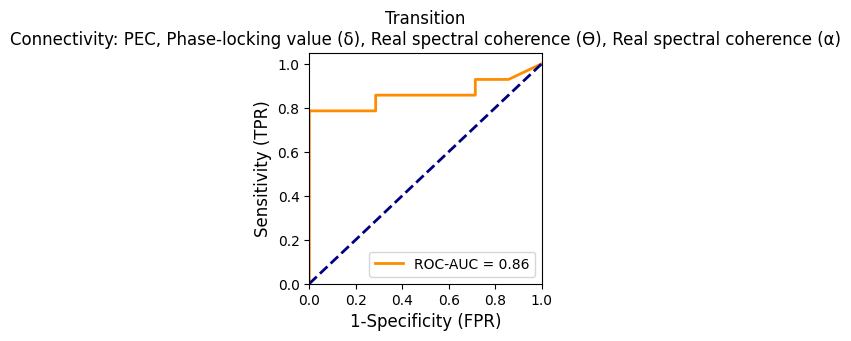

The AUC is: 0.8622448979591838, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


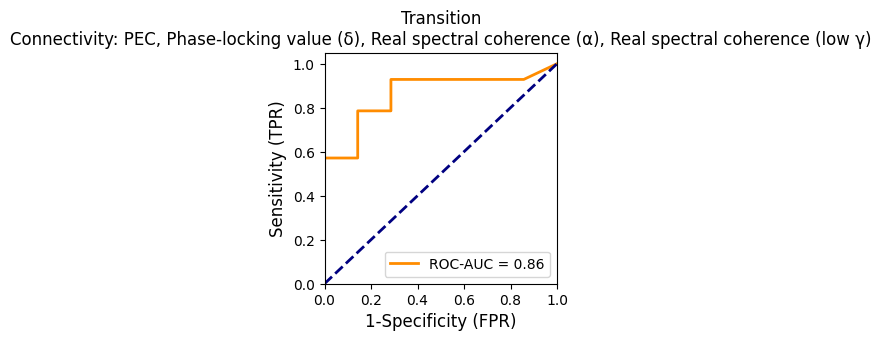

The AUC is: 0.8673469387755102, Sensitivity: 0.7857142857142857, Specificity: 1.0


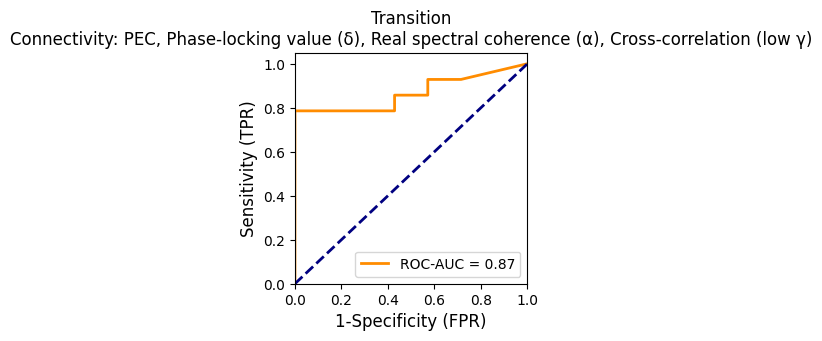

The AUC is: 0.8622448979591837, Sensitivity: 0.7142857142857143, Specificity: 1.0


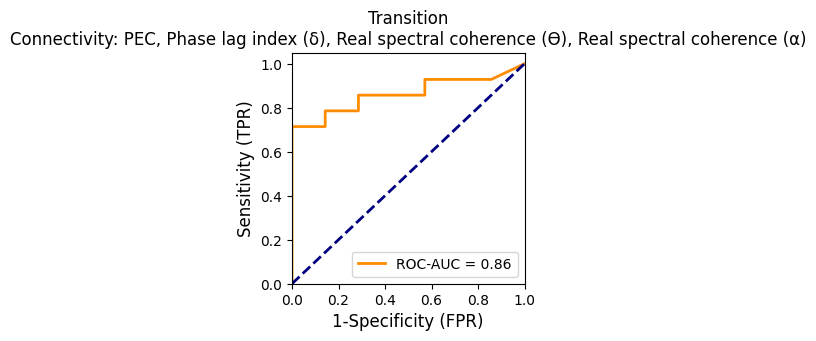

The AUC is: 0.8724489795918366, Sensitivity: 0.7142857142857143, Specificity: 1.0


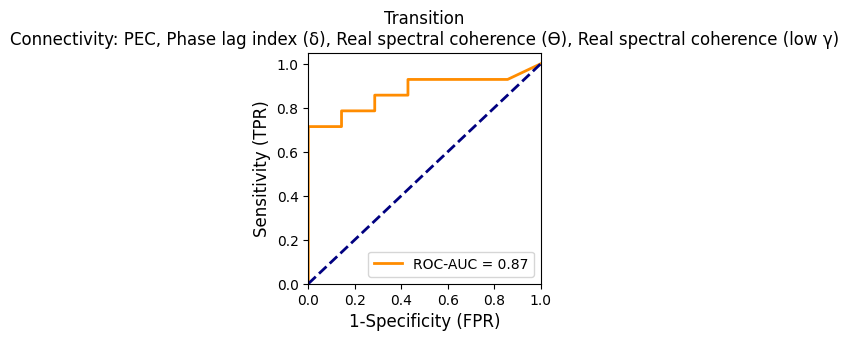

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


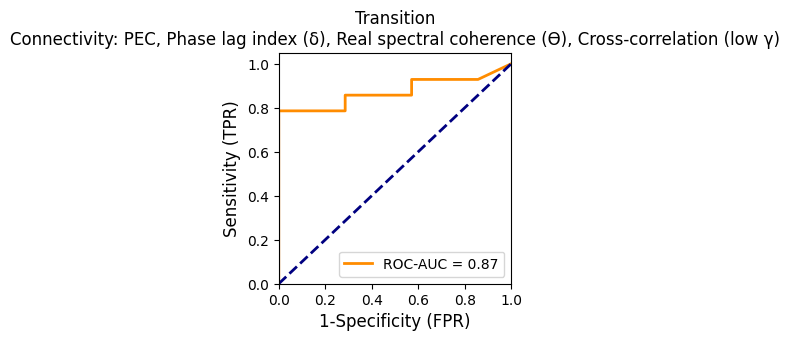

The AUC is: 0.8622448979591838, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


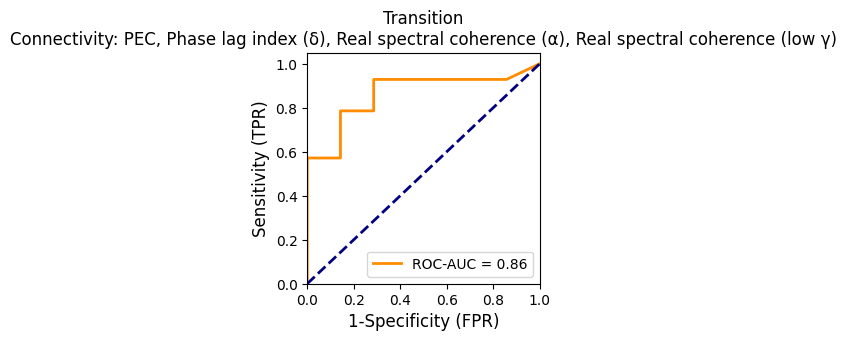

The AUC is: 0.8571428571428571, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


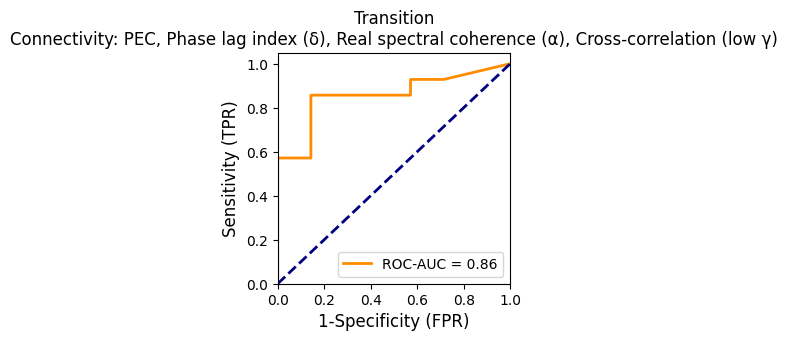

The AUC is: 0.8928571428571428, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


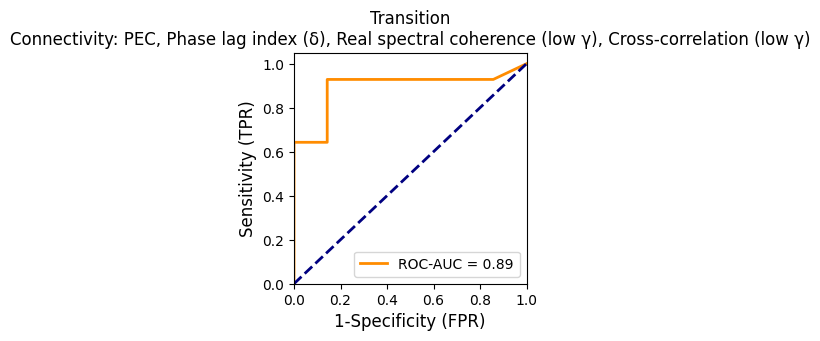

The AUC is: 0.8724489795918369, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


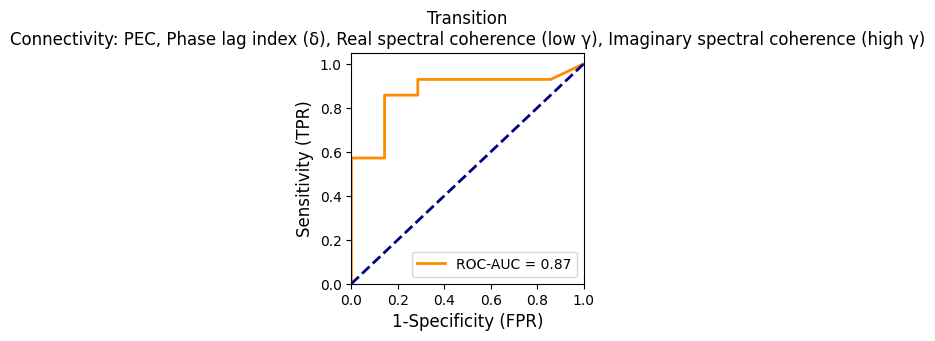

The AUC is: 0.892857142857143, Sensitivity: 0.7142857142857143, Specificity: 1.0


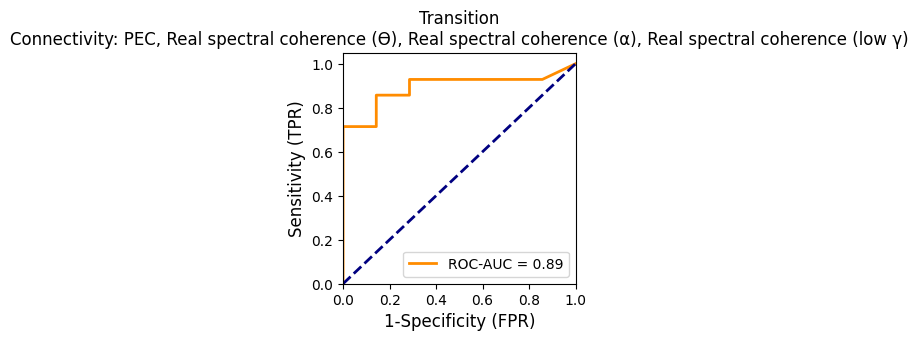

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


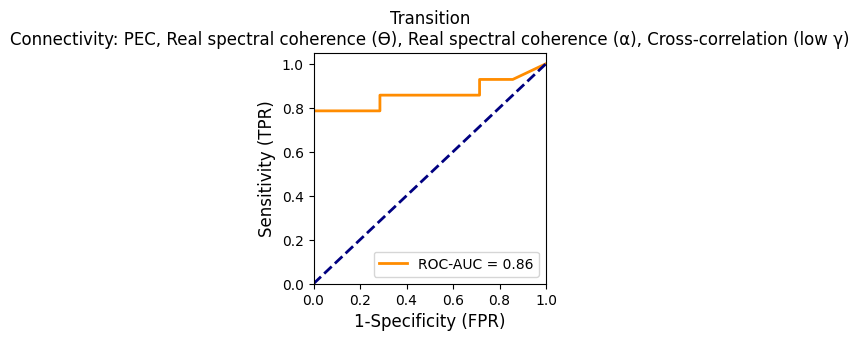

The AUC is: 0.8520408163265306, Sensitivity: 0.7142857142857143, Specificity: 1.0


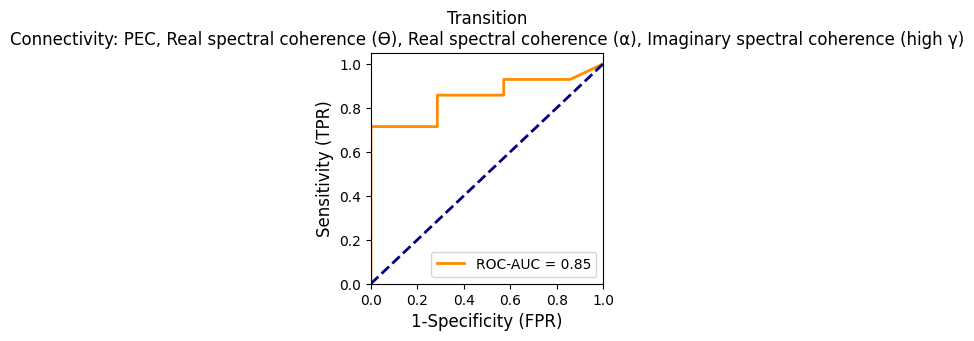

The AUC is: 0.8826530612244898, Sensitivity: 0.7142857142857143, Specificity: 1.0


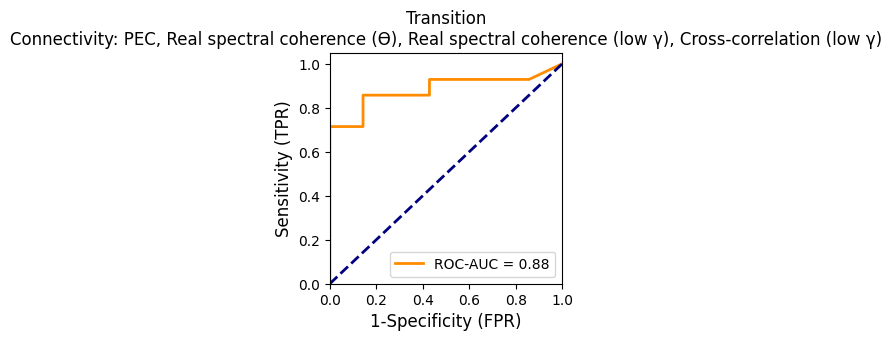

The AUC is: 0.8520408163265306, Sensitivity: 0.7142857142857143, Specificity: 1.0


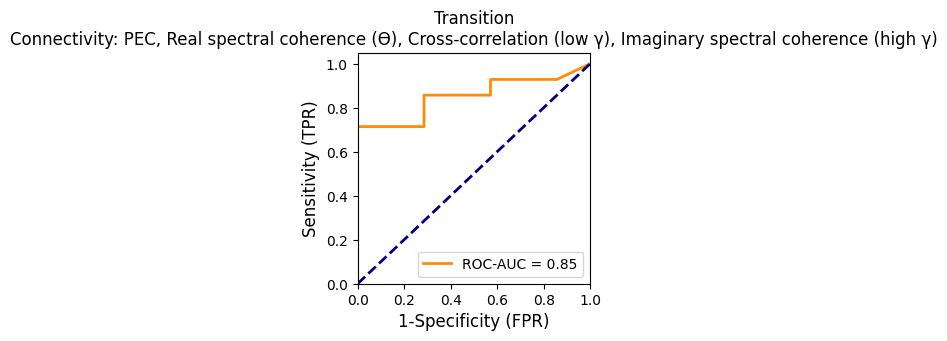

The AUC is: 0.8520408163265307, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


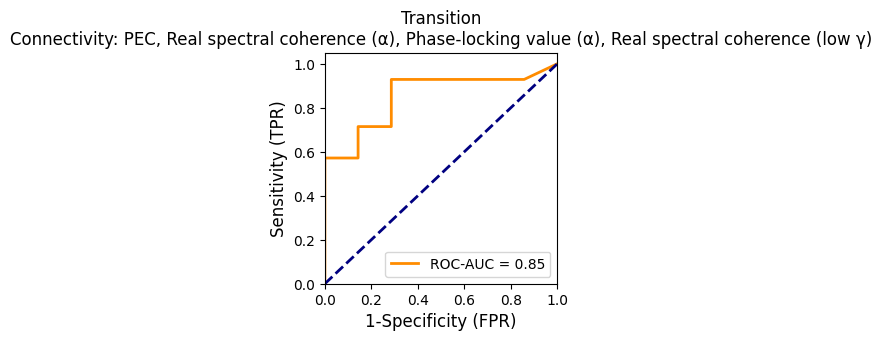

The AUC is: 0.8571428571428572, Sensitivity: 0.7857142857142857, Specificity: 1.0


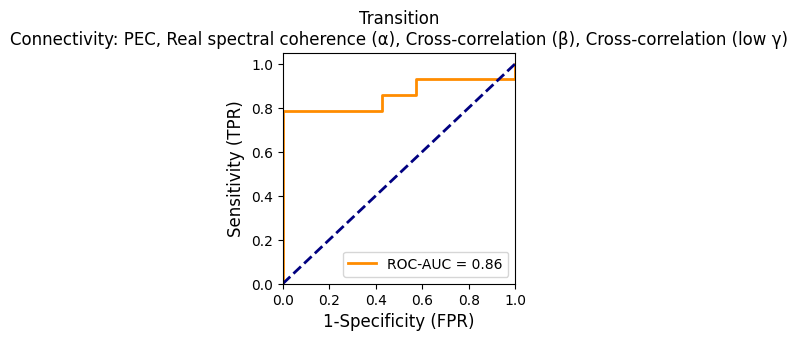

The AUC is: 0.8622448979591837, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


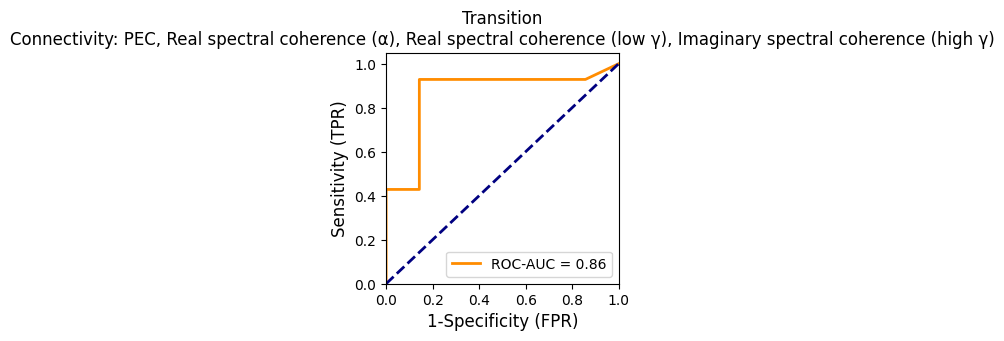

The AUC is: 0.8571428571428571, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


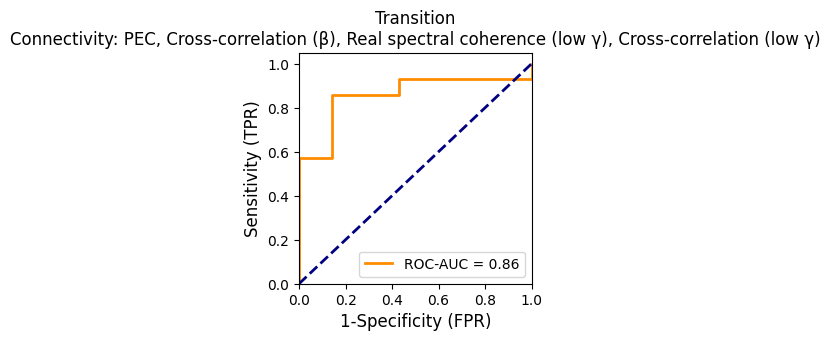

The AUC is: 0.8622448979591837, Sensitivity: 0.9285714285714286, Specificity: 0.8571428571428572


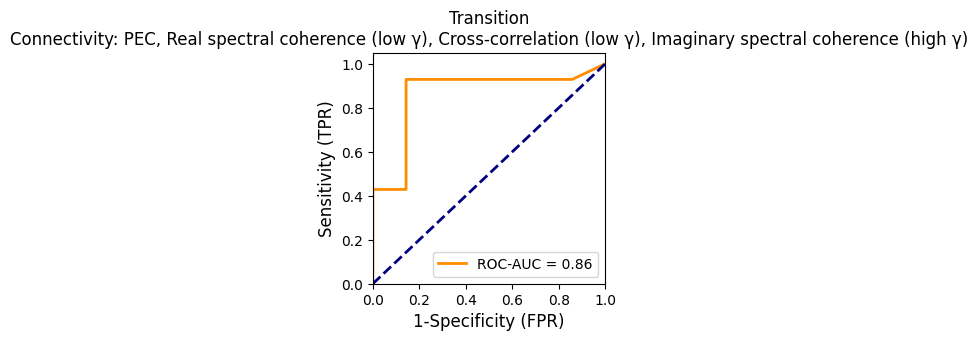

The AUC is: 0.8622448979591836, Sensitivity: 0.7142857142857143, Specificity: 1.0


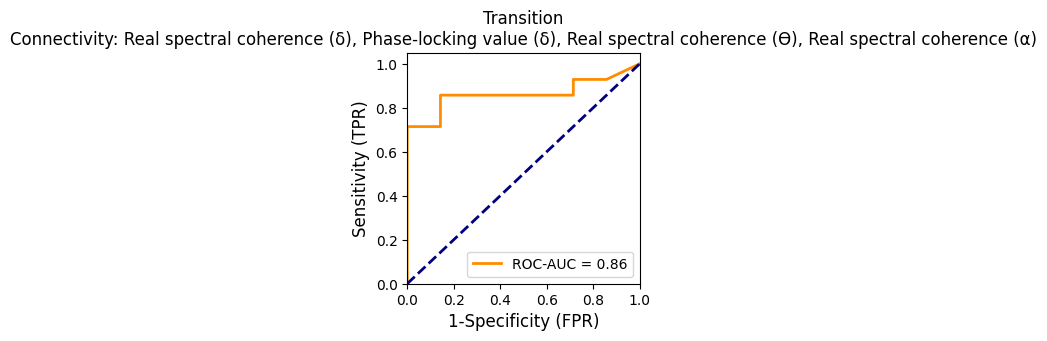

The AUC is: 0.8673469387755102, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


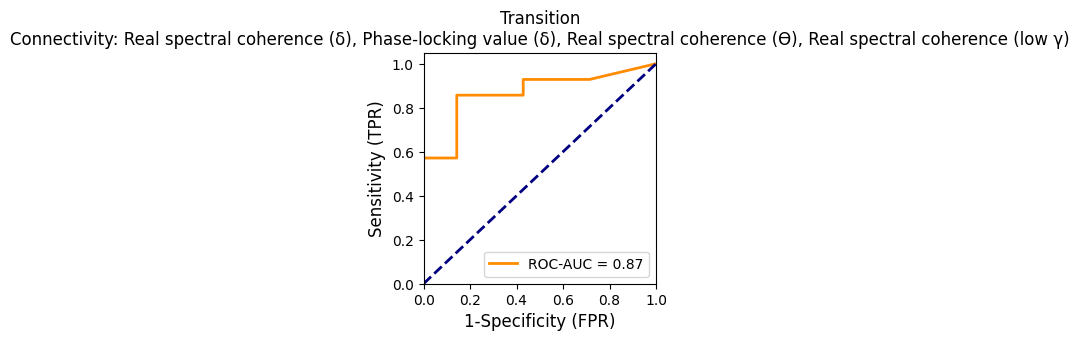

The AUC is: 0.8520408163265306, Sensitivity: 0.7142857142857143, Specificity: 1.0


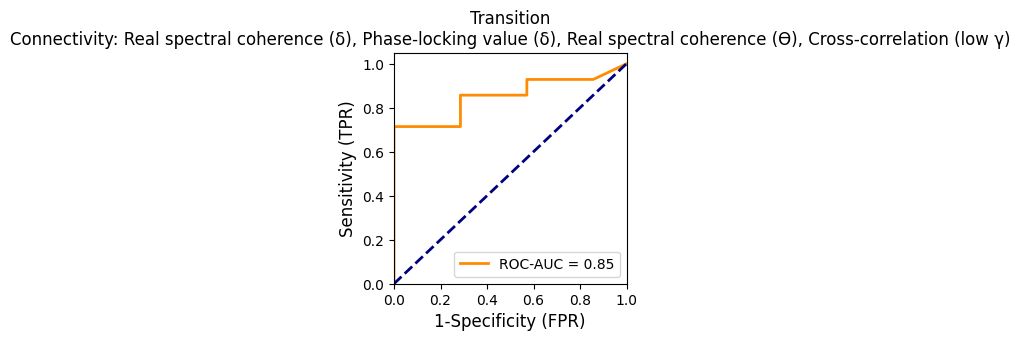

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


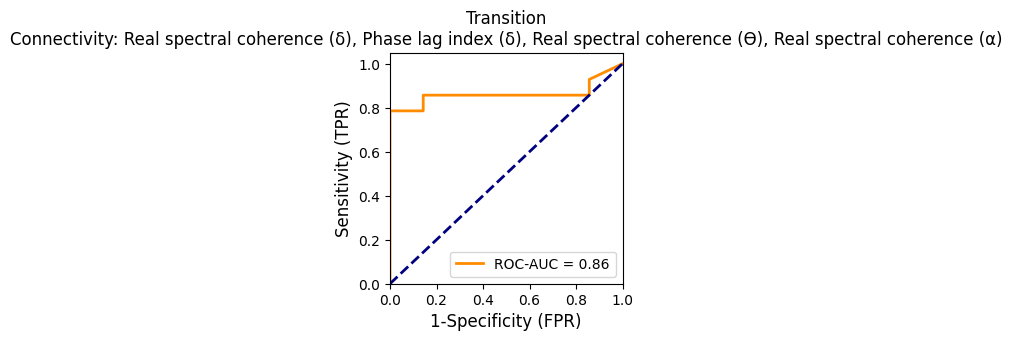

The AUC is: 0.8724489795918369, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


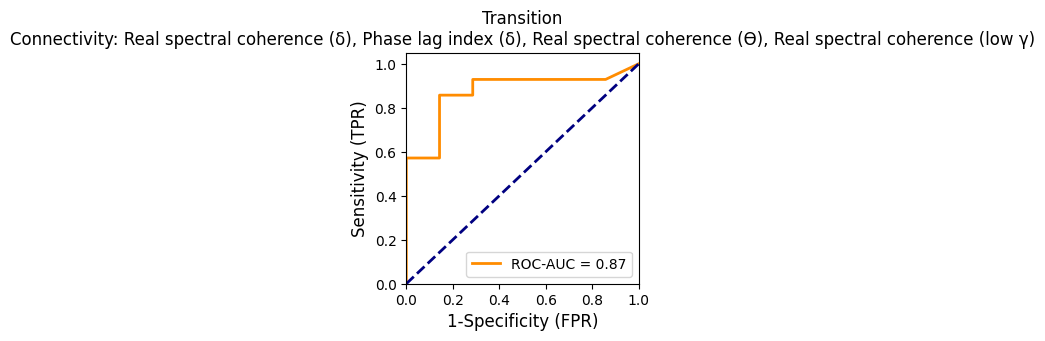

The AUC is: 0.8622448979591838, Sensitivity: 0.9285714285714286, Specificity: 0.7142857142857143


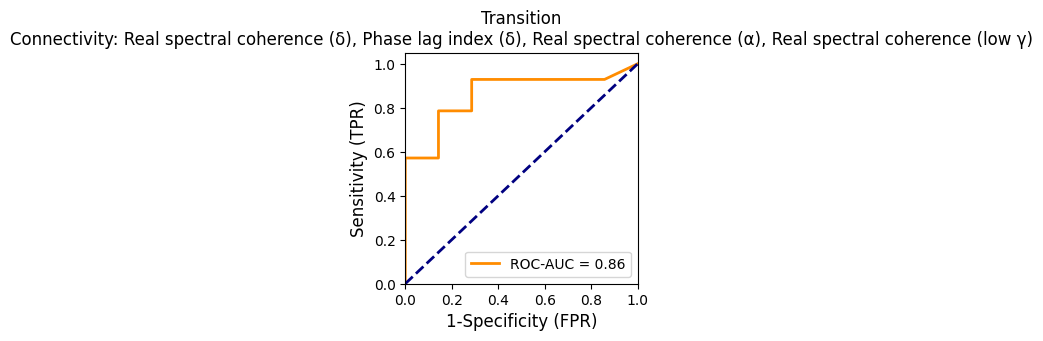

The AUC is: 0.8520408163265307, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


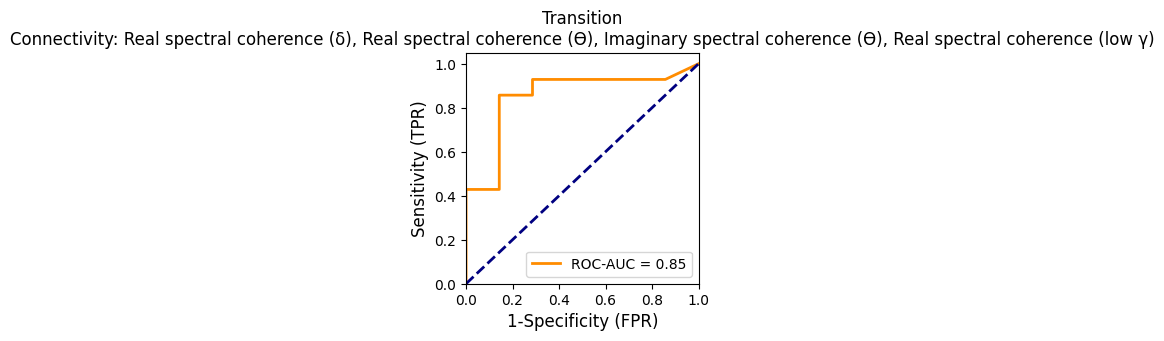

The AUC is: 0.8622448979591838, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


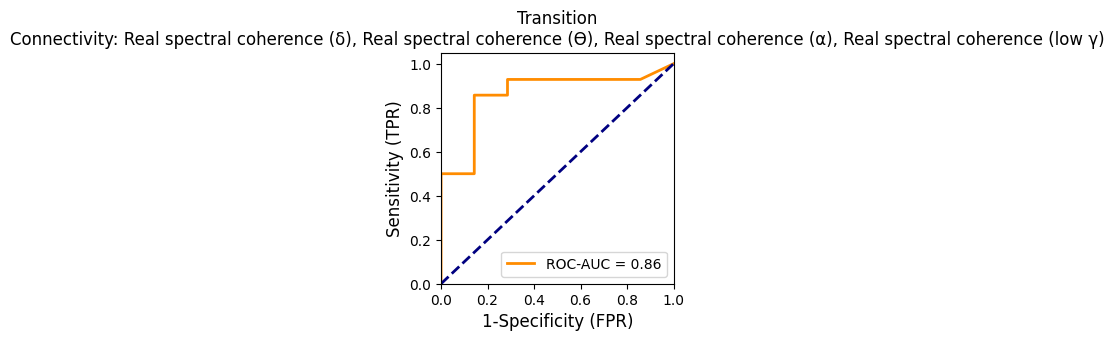

The AUC is: 0.8826530612244898, Sensitivity: 0.7857142857142857, Specificity: 1.0


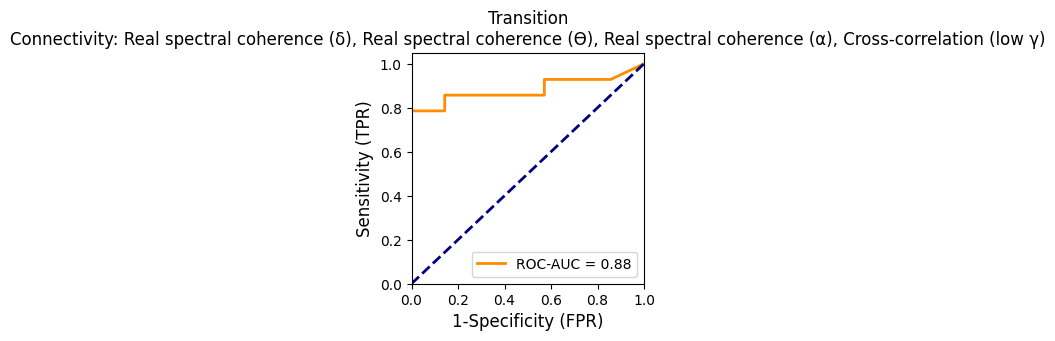

The AUC is: 0.8520408163265307, Sensitivity: 0.7142857142857143, Specificity: 1.0


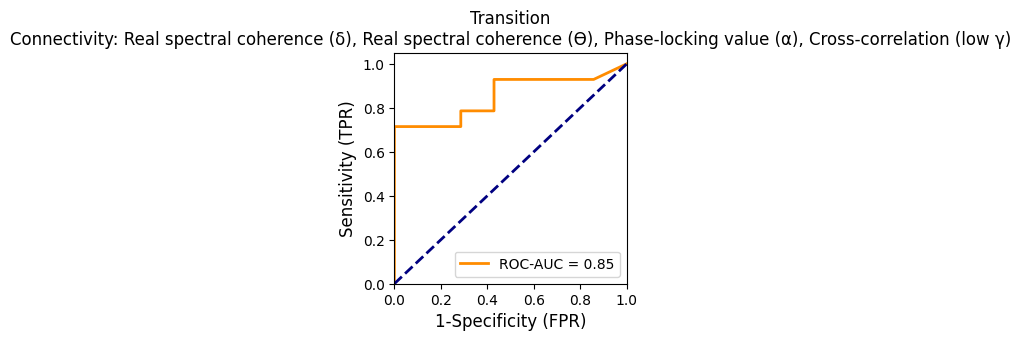

The AUC is: 0.8571428571428572, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


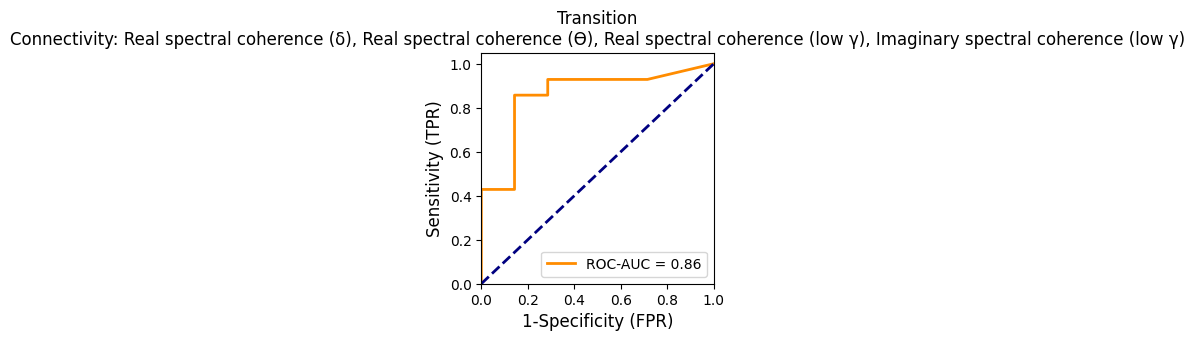

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


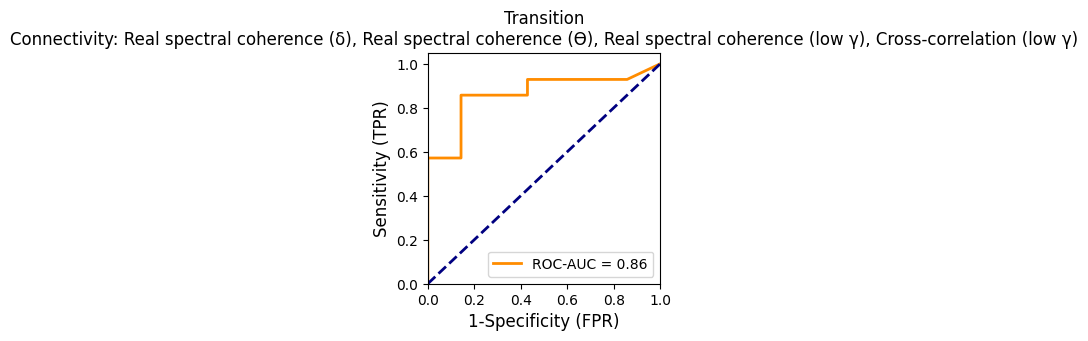

The AUC is: 0.8520408163265307, Sensitivity: 0.7142857142857143, Specificity: 1.0


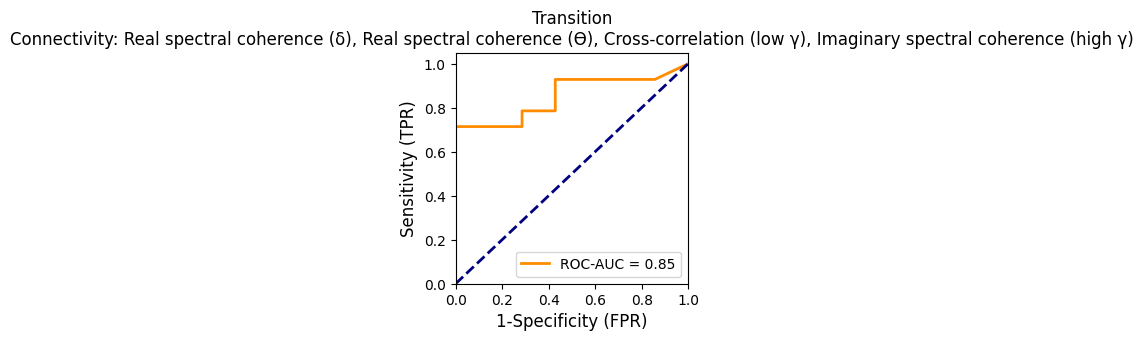

The AUC is: 0.8571428571428572, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


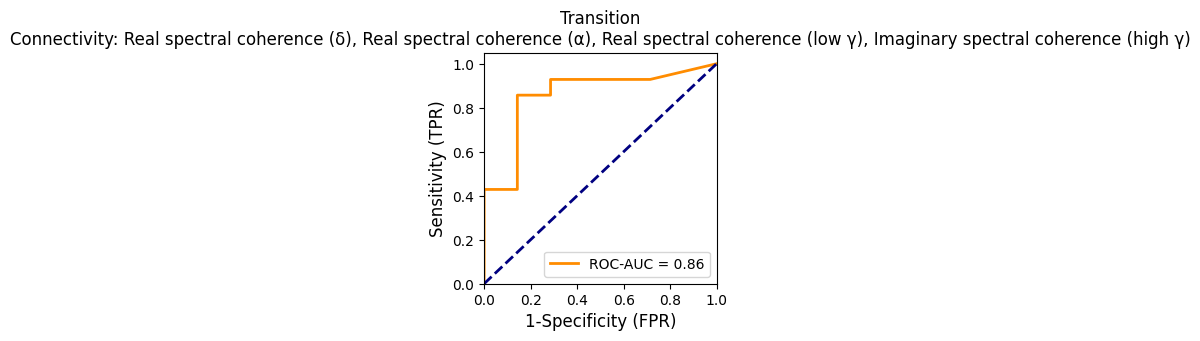

The AUC is: 0.8520408163265306, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


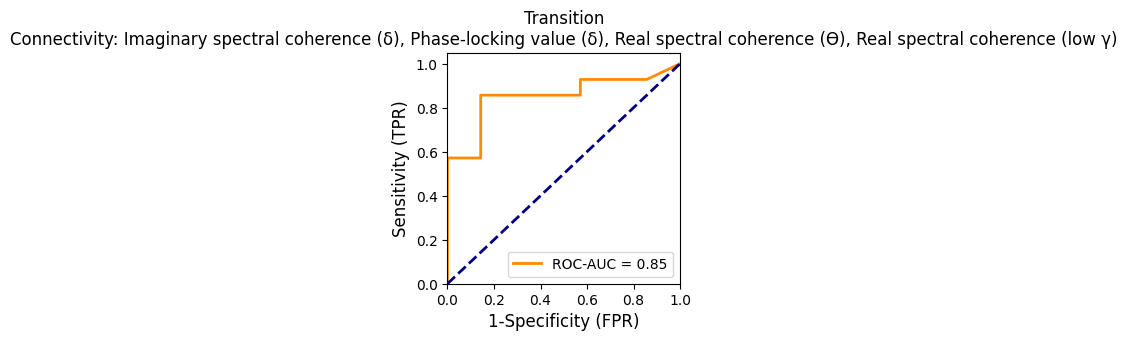

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


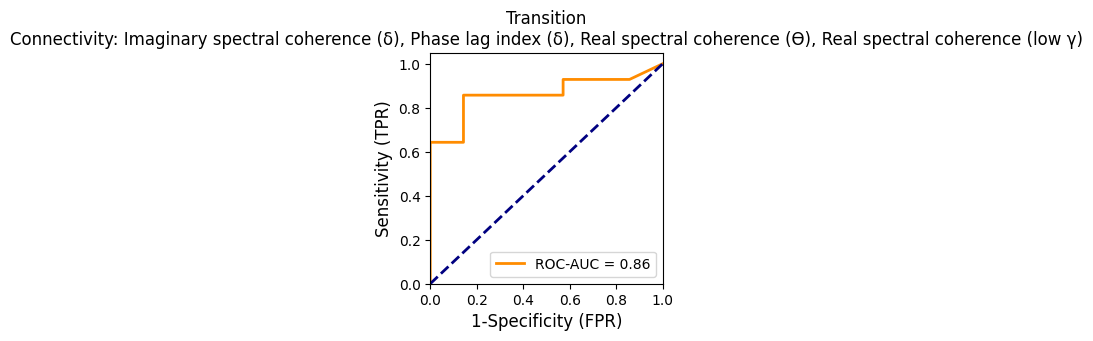

The AUC is: 0.8724489795918368, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


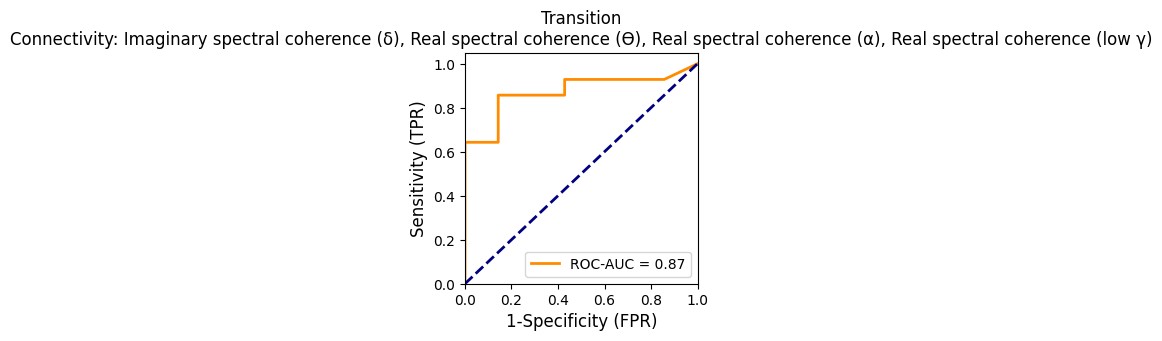

The AUC is: 0.8520408163265307, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


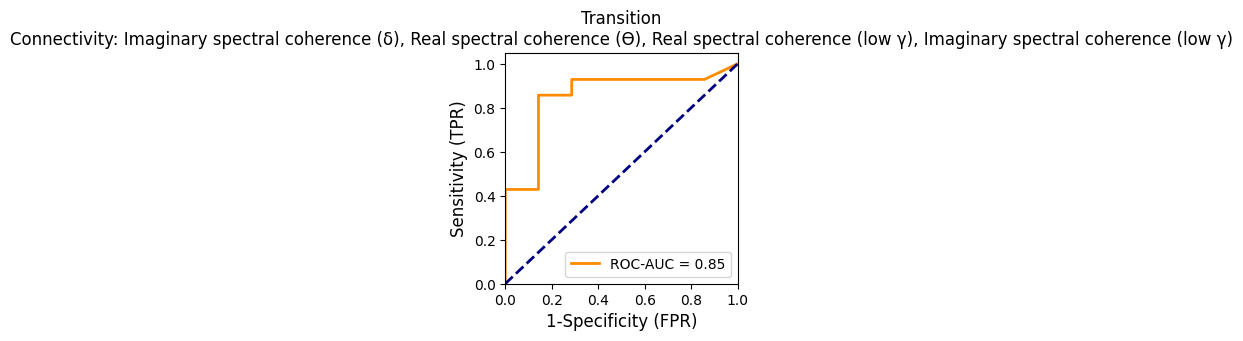

The AUC is: 0.8520408163265305, Sensitivity: 0.7857142857142857, Specificity: 1.0


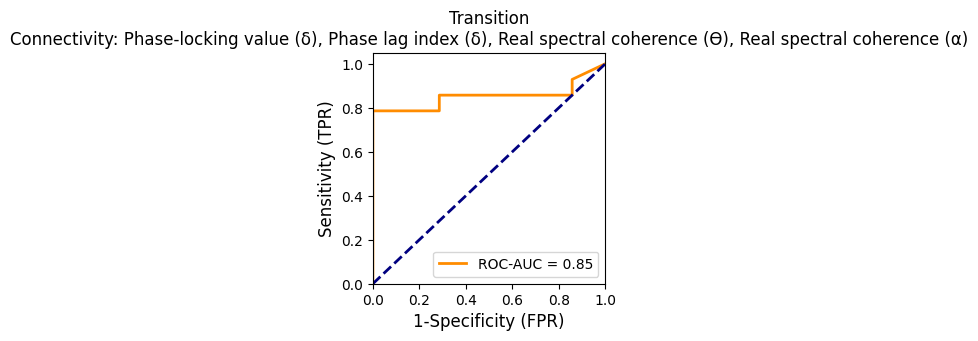

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


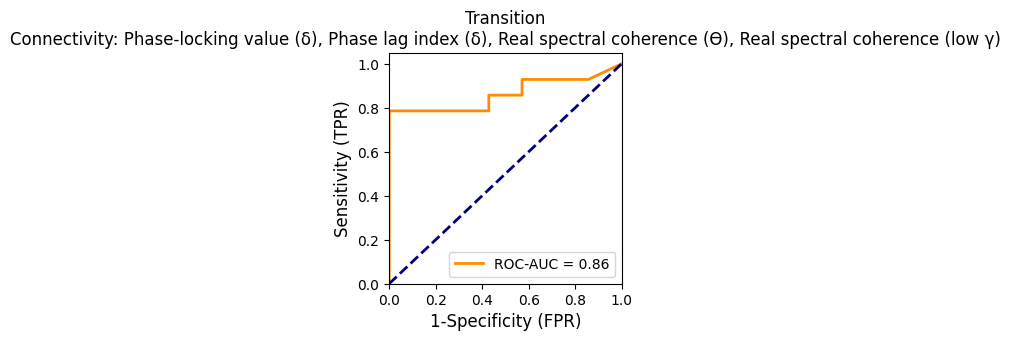

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


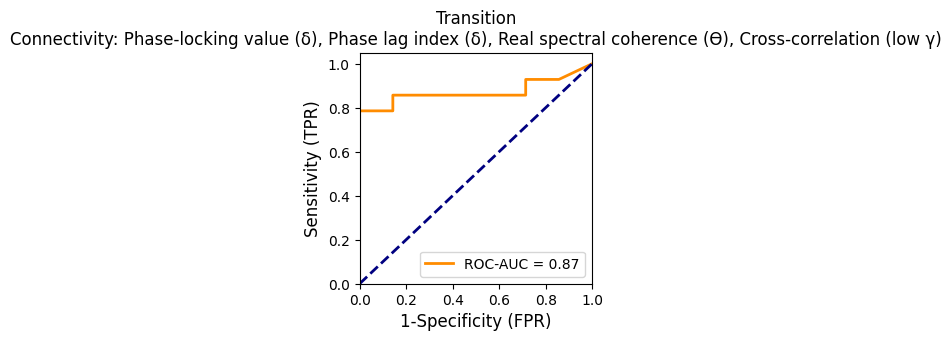

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


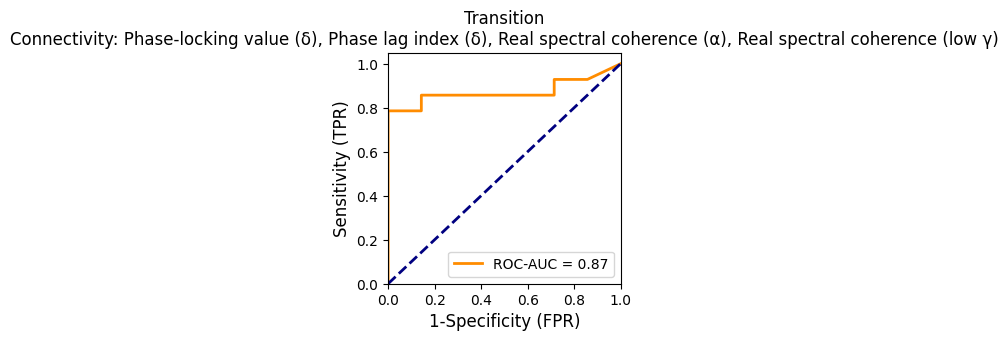

The AUC is: 0.8571428571428571, Sensitivity: 0.7857142857142857, Specificity: 1.0


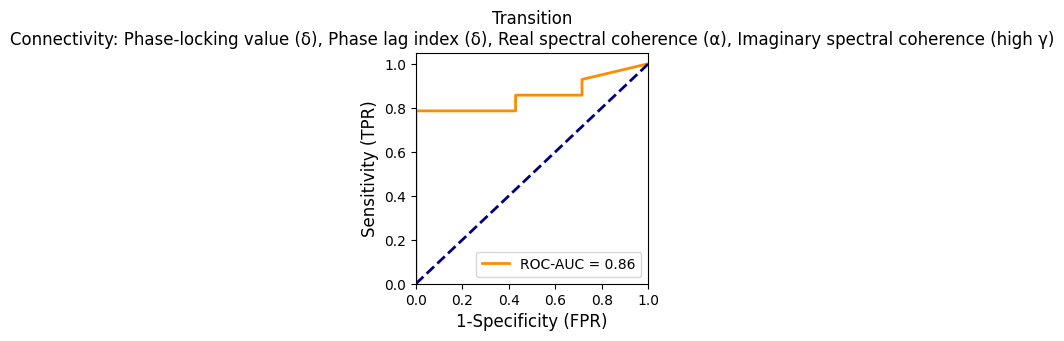

The AUC is: 0.8520408163265307, Sensitivity: 0.7857142857142857, Specificity: 1.0


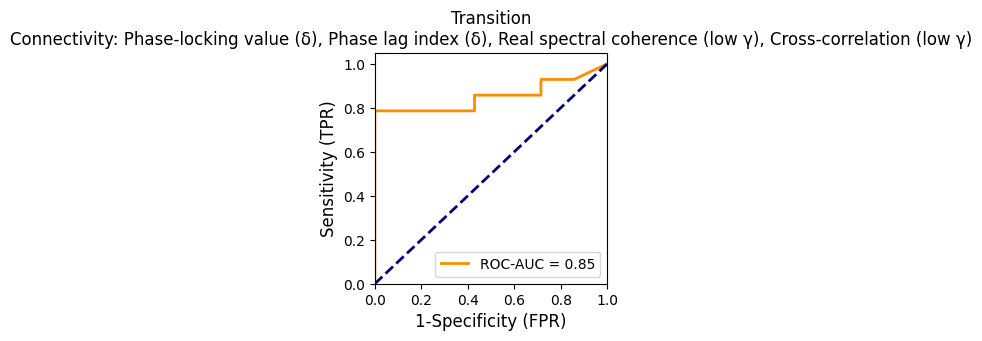

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


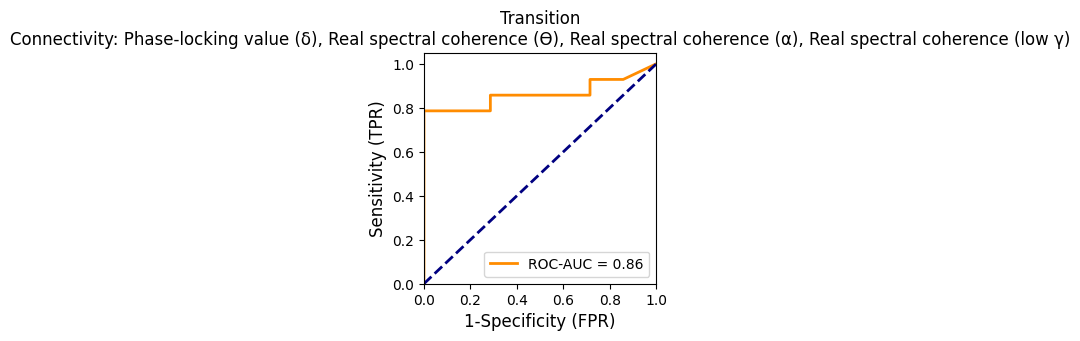

The AUC is: 0.8622448979591836, Sensitivity: 0.7142857142857143, Specificity: 1.0


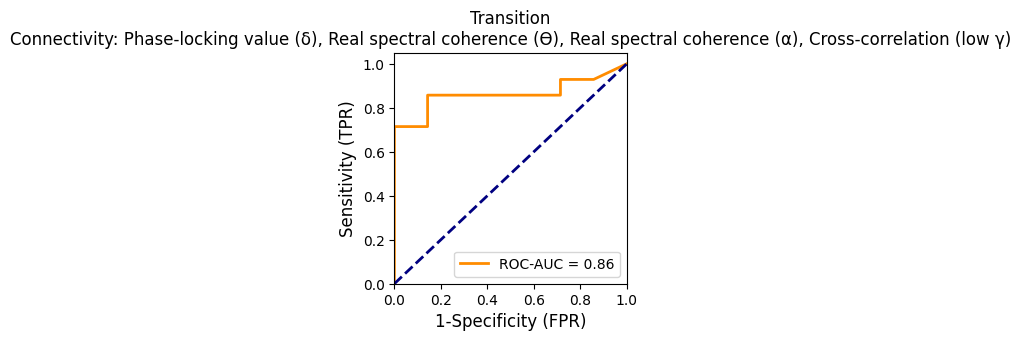

The AUC is: 0.8520408163265307, Sensitivity: 0.7142857142857143, Specificity: 1.0


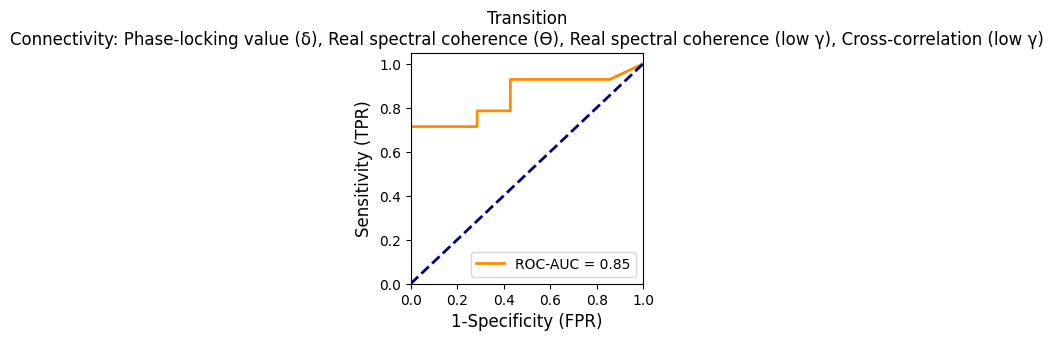

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


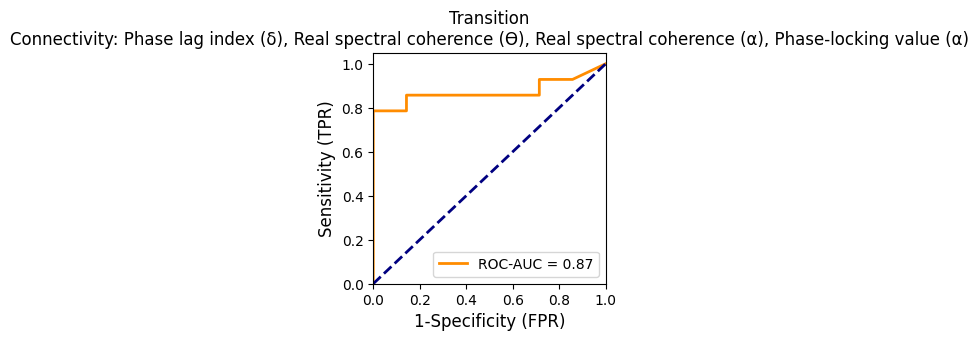

The AUC is: 0.8928571428571428, Sensitivity: 0.8571428571428571, Specificity: 1.0


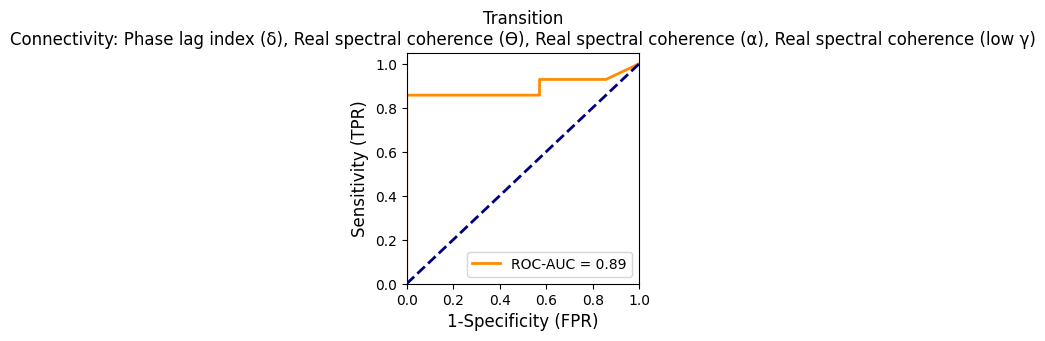

The AUC is: 0.8571428571428572, Sensitivity: 0.7857142857142857, Specificity: 1.0


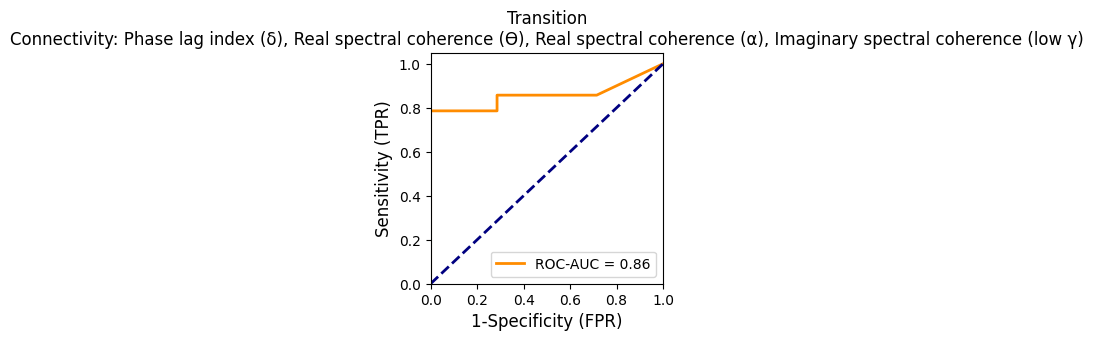

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


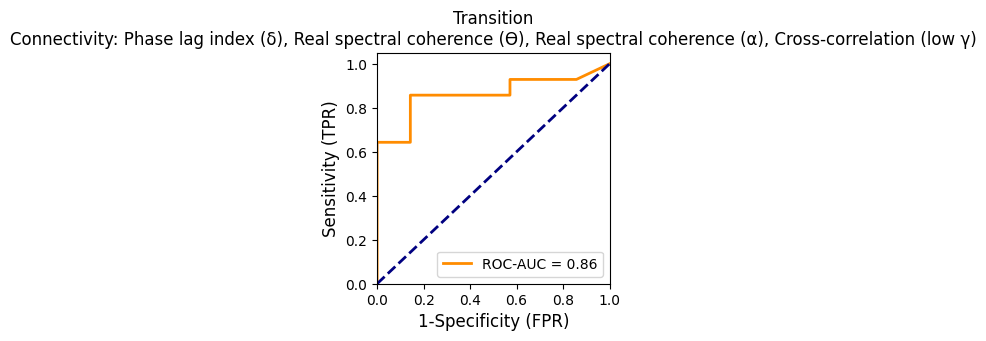

The AUC is: 0.8571428571428571, Sensitivity: 0.7857142857142857, Specificity: 1.0


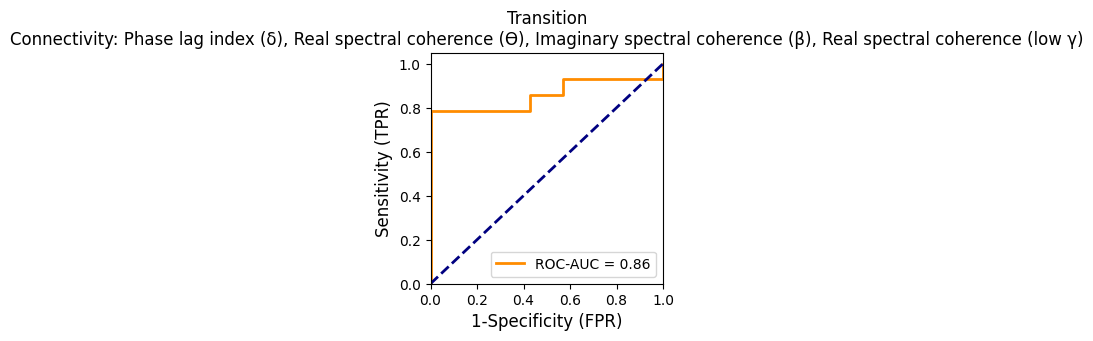

The AUC is: 0.8520408163265307, Sensitivity: 0.7142857142857143, Specificity: 1.0


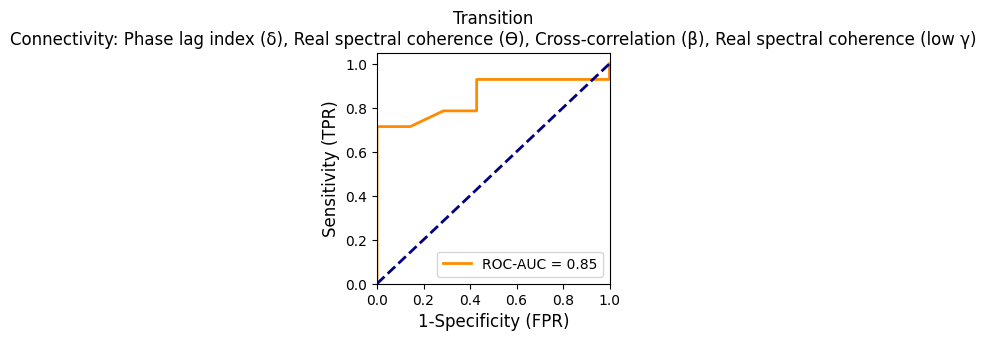

The AUC is: 0.8928571428571428, Sensitivity: 0.8571428571428571, Specificity: 1.0


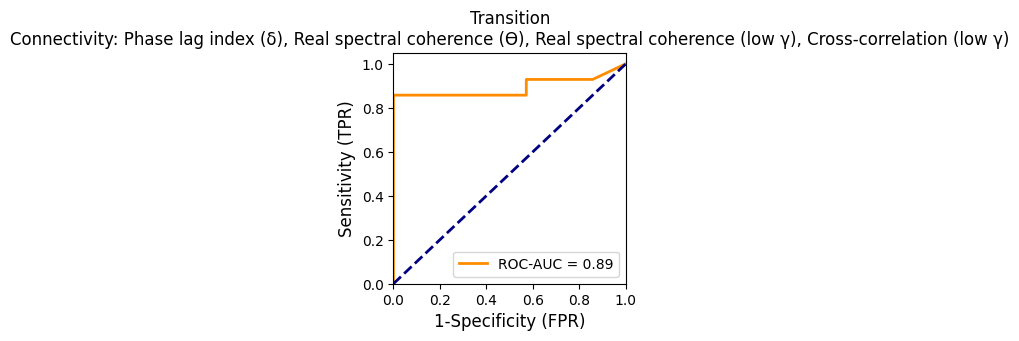

The AUC is: 0.8724489795918368, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


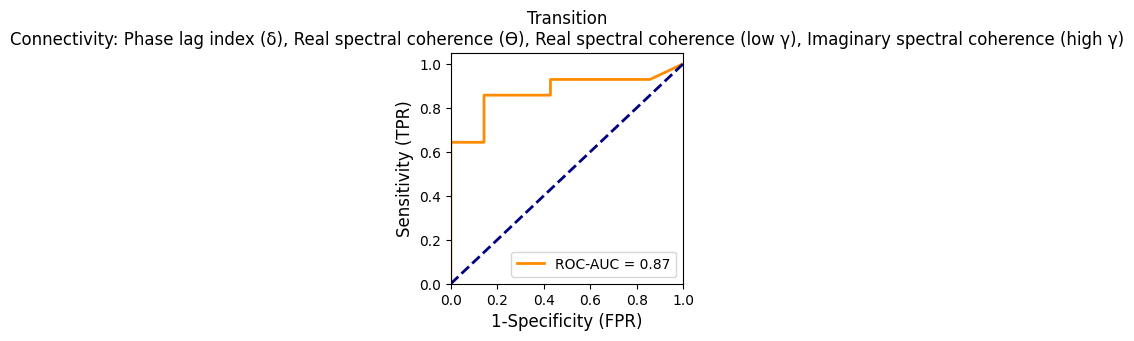

The AUC is: 0.8724489795918366, Sensitivity: 0.7857142857142857, Specificity: 1.0


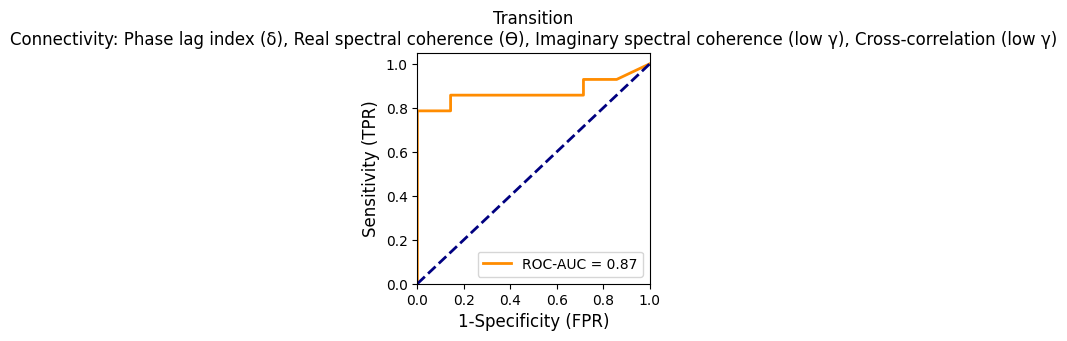

The AUC is: 0.8826530612244899, Sensitivity: 0.7142857142857143, Specificity: 1.0


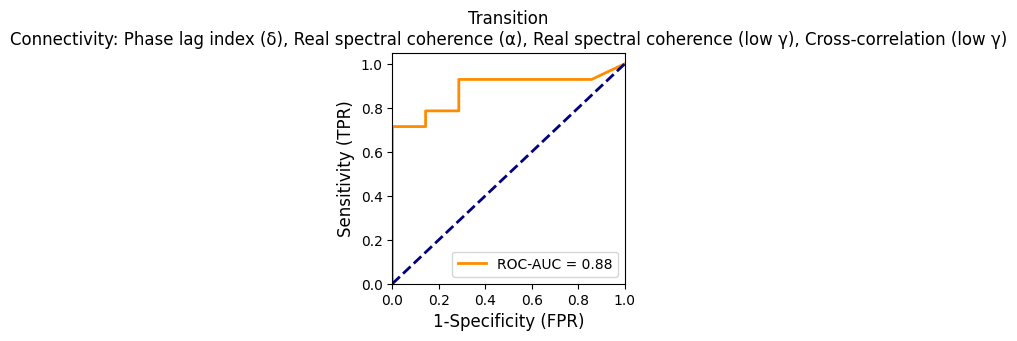

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


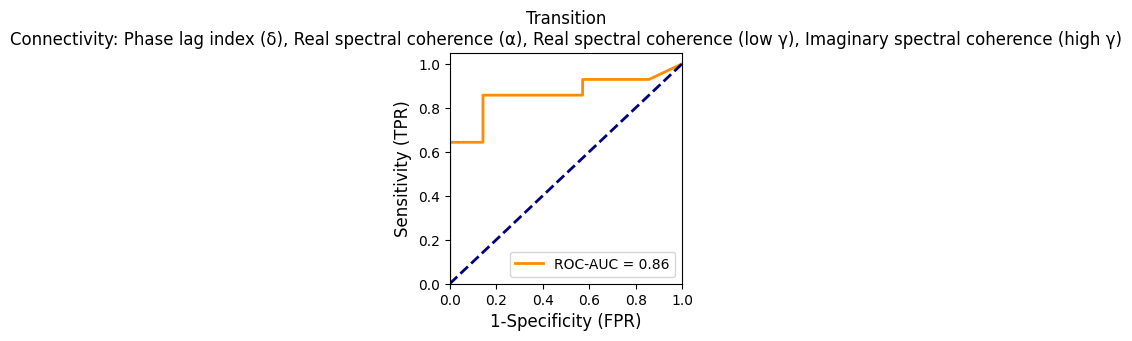

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


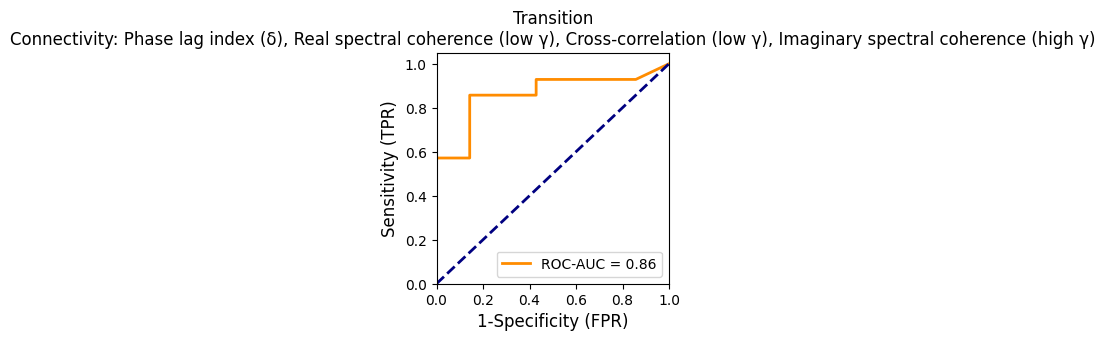

The AUC is: 0.8724489795918368, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


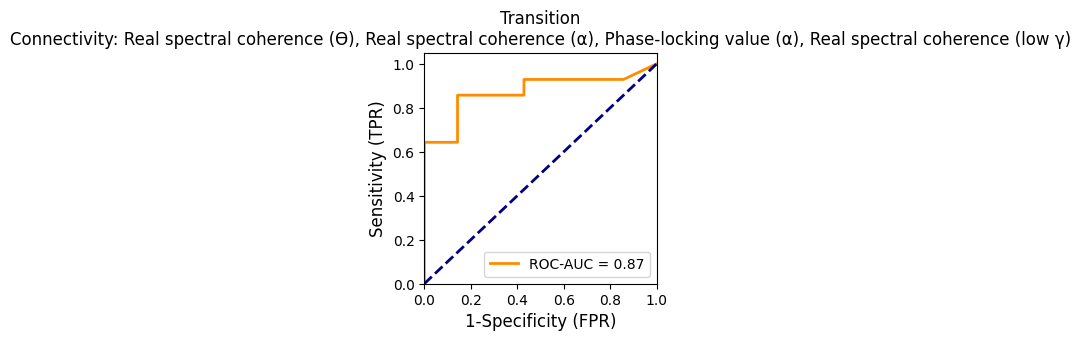

The AUC is: 0.8673469387755102, Sensitivity: 0.7142857142857143, Specificity: 1.0


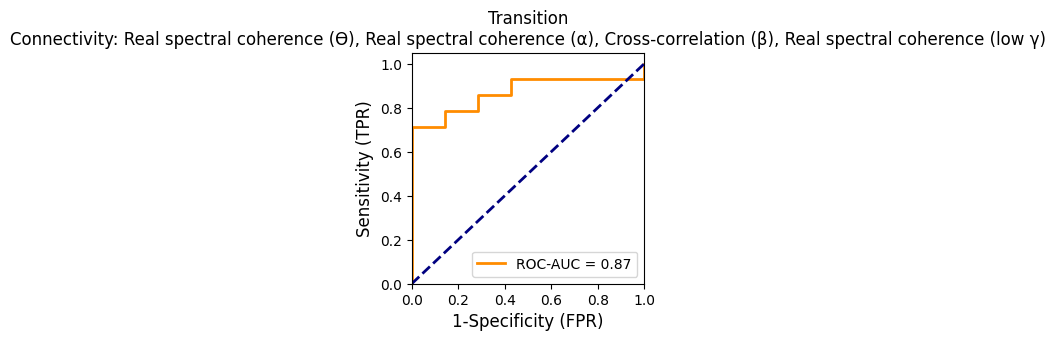

The AUC is: 0.903061224489796, Sensitivity: 0.8571428571428571, Specificity: 1.0


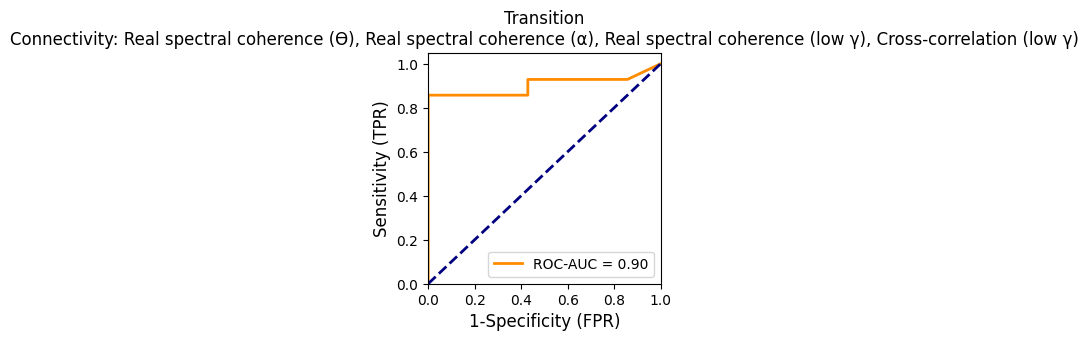

The AUC is: 0.8622448979591837, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


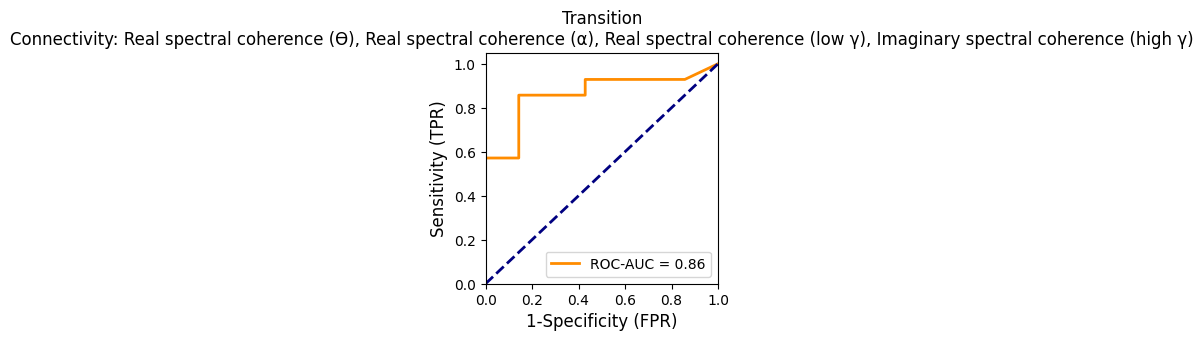

The AUC is: 0.8673469387755103, Sensitivity: 0.7142857142857143, Specificity: 1.0


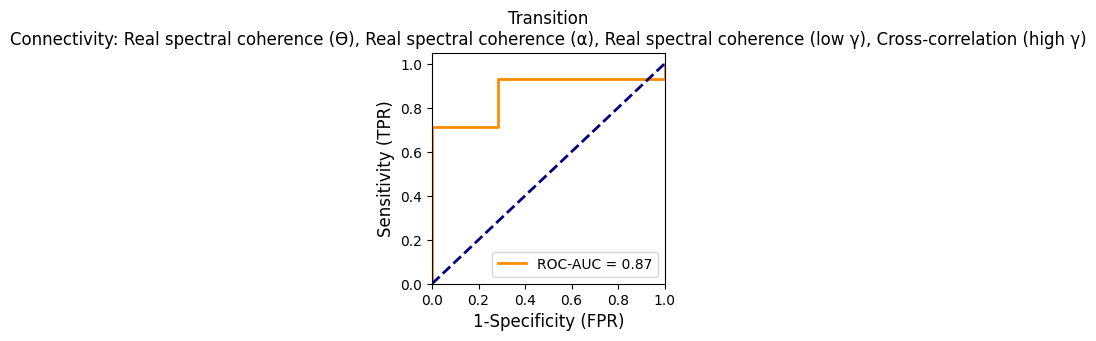

The AUC is: 0.8622448979591837, Sensitivity: 0.7857142857142857, Specificity: 1.0


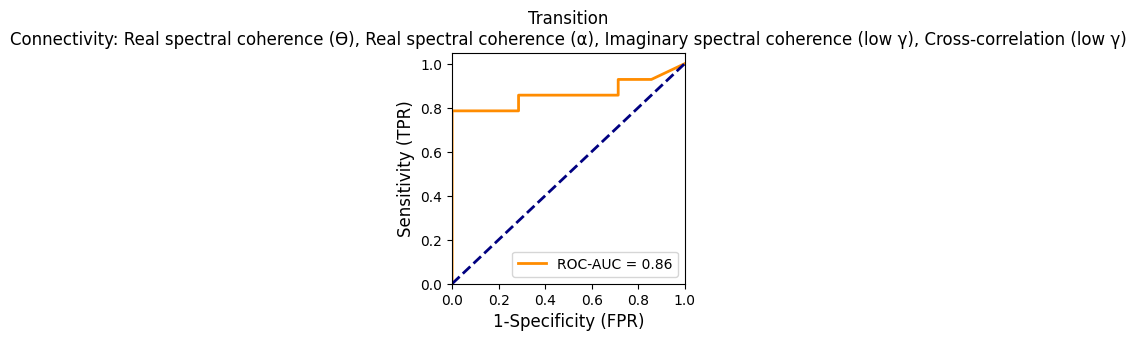

The AUC is: 0.8622448979591836, Sensitivity: 0.7142857142857143, Specificity: 1.0


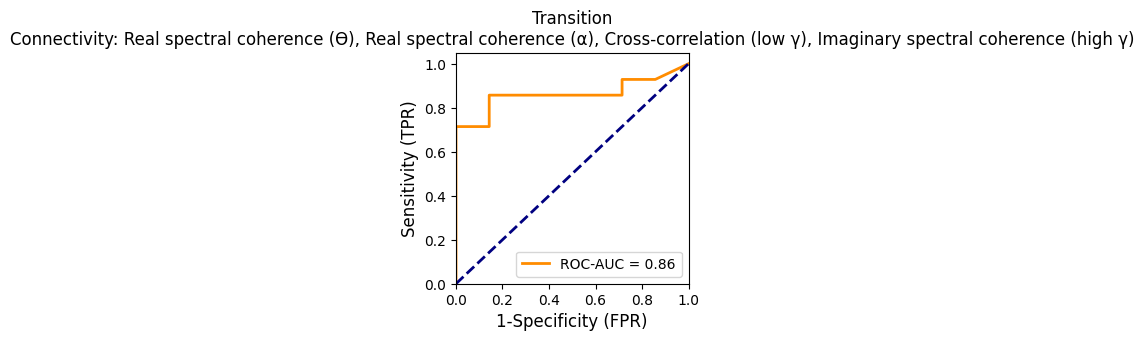

The AUC is: 0.8622448979591838, Sensitivity: 0.6428571428571429, Specificity: 1.0


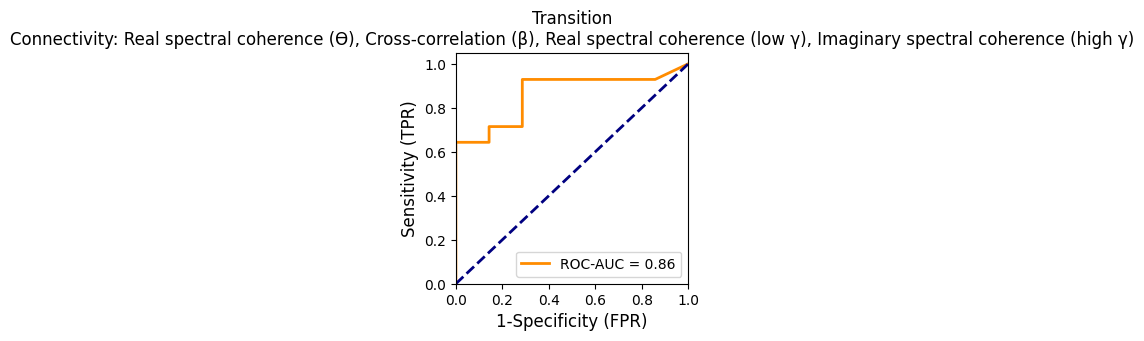

The AUC is: 0.8724489795918369, Sensitivity: 0.6428571428571429, Specificity: 1.0


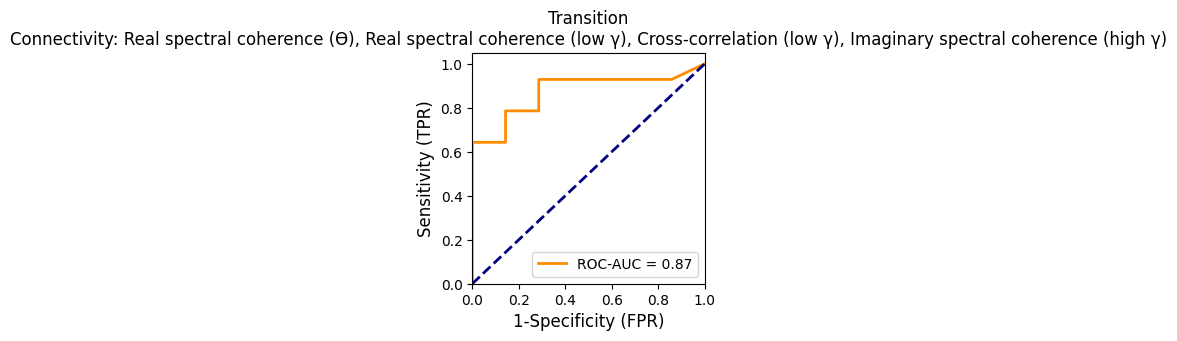

The AUC is: 0.8571428571428571, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


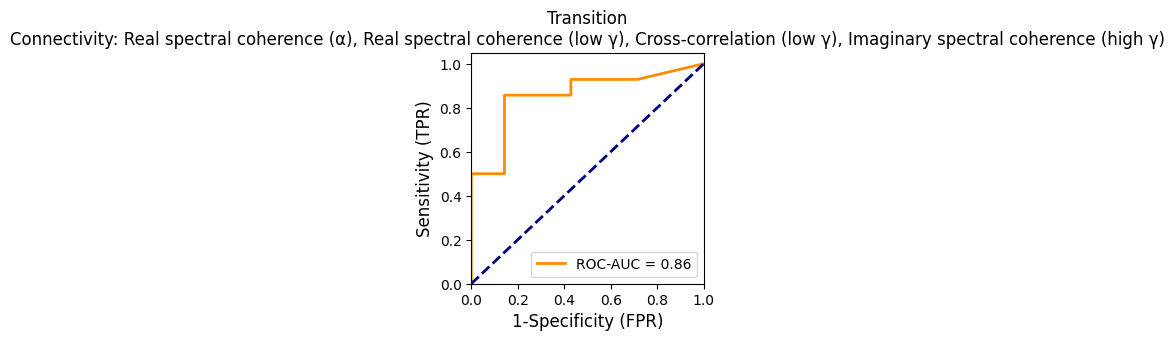

In [ ]:
# Generate combinations of 4 connectivity measures
# combinations = [('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'), ('PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'), ('CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)'),
# ('PEC', 'PAC', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PLI(1,4)', 'PLV(4,8)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'CC(13,30)', 'CC(30,70)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_I(70,150)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(30,70)'),
# ('PEC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PLV(70,150)', 'SC_I(1,4)', 'SC_R(30,70)'),
# ('PEC', 'CC(13,30)', 'CC(30,70)', 'SC_R(8,12)'),
# ('PEC', 'CC(30,70)', 'SC_I(70,150)', 'SC_R(30,70)'),
# ('PEC', 'CC(30,70)', 'SC_R(1,4)', 'SC_R(4,8)')]

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures,4):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.85:

              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              woi_str = ''
              if woi=="NS": woi_str = "Transition"
              elif woi=="N60S": woi_str = "Pre-seizure"
              elif woi=="NE": woi_str = "Seizure"
              elif woi=="NN": woi_str = "Non-seizure"

              cm_str = substitute_cm(combination_str)
              cm_str = substitute_bands(cm_str)

              plt.figure(figsize=(3,3))
              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('1-Specificity (FPR)', size=12)
              plt.ylabel('Sensitivity (TPR)', size=12)
              plt.title(f'{woi_str}\nConnectivity: {cm_str}')
              plt.legend(loc="lower right")
              plt.show()
              plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "4cm_rocauc_results.xlsx", index=False)

Combinations of 5 connectivity measures:

In [ ]:
# Generate combinations of 5 connectivity measures
# combinations = [('PEC', 'PLI(1,4)', 'SC_I(8,12)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'CC(30,70)', 'SC_I(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLV(1,4)', 'CC(30,70)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLV(70,150)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'CC(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'SC_I(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'SC_R(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PLI(1,4)', 'PLI(70,150)', 'SC_I(1,4)', 'SC_R(4,8)')]


results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 5):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.8:

              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              woi_str = ''
              if woi=="NS": woi_str = "Transition"
              elif woi=="N60S": woi_str = "Pre-seizure"
              elif woi=="NE": woi_str = "Seizure"
              elif woi=="NN": woi_str = "Non-seizure"

              cm_str = substitute_cm(combination_str)
              cm_str = substitute_bands(cm_str)

              plt.figure(figsize=(3,3))
              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('1-Specificity (FPR)', size=12)
              plt.ylabel('Sensitivity (TPR)', size=12)
              plt.title(f'{woi_str}\nConnectivity: {cm_str}')
              plt.legend(loc="lower right")
              plt.show()
              plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "5cm_rocauc_results.xlsx", index=False)

In [ ]:
import seaborn as sns

wois=["NN","N60S","NS","NE"]

xd,yd,hue=[],[],[]

for it in range(1,6):

  for woi in wois:

    f = "{}cm_rocauc_results.xlsx".format(it)

    df = pd.read_excel(main_folder+f)
    df = df[df['WOI'] == woi]

    # take only the top ROC-AUCs (above threshold)
    # define threshold as mean (above-average)
    df_top = df[df['AUC'] >= df['AUC'].mean()]

    ytemp=list(df_top['AUC'])
    yd+=list(ytemp)
    xd+=[str(it)]*len(ytemp)

    if woi=="NS": hue+=["transition"]*len(ytemp)
    elif woi=="N60S": hue+=["pre-seizure"]*len(ytemp)
    elif woi=="NE": hue+=["seizure"]*len(ytemp)
    elif woi=="NN": hue+=["non-seizure"]*len(ytemp)

datasorted = {"xd":xd,
      "hue_woi":hue,
      "yd":yd}

Text(0.5, 0, 'Multiscore combination size')

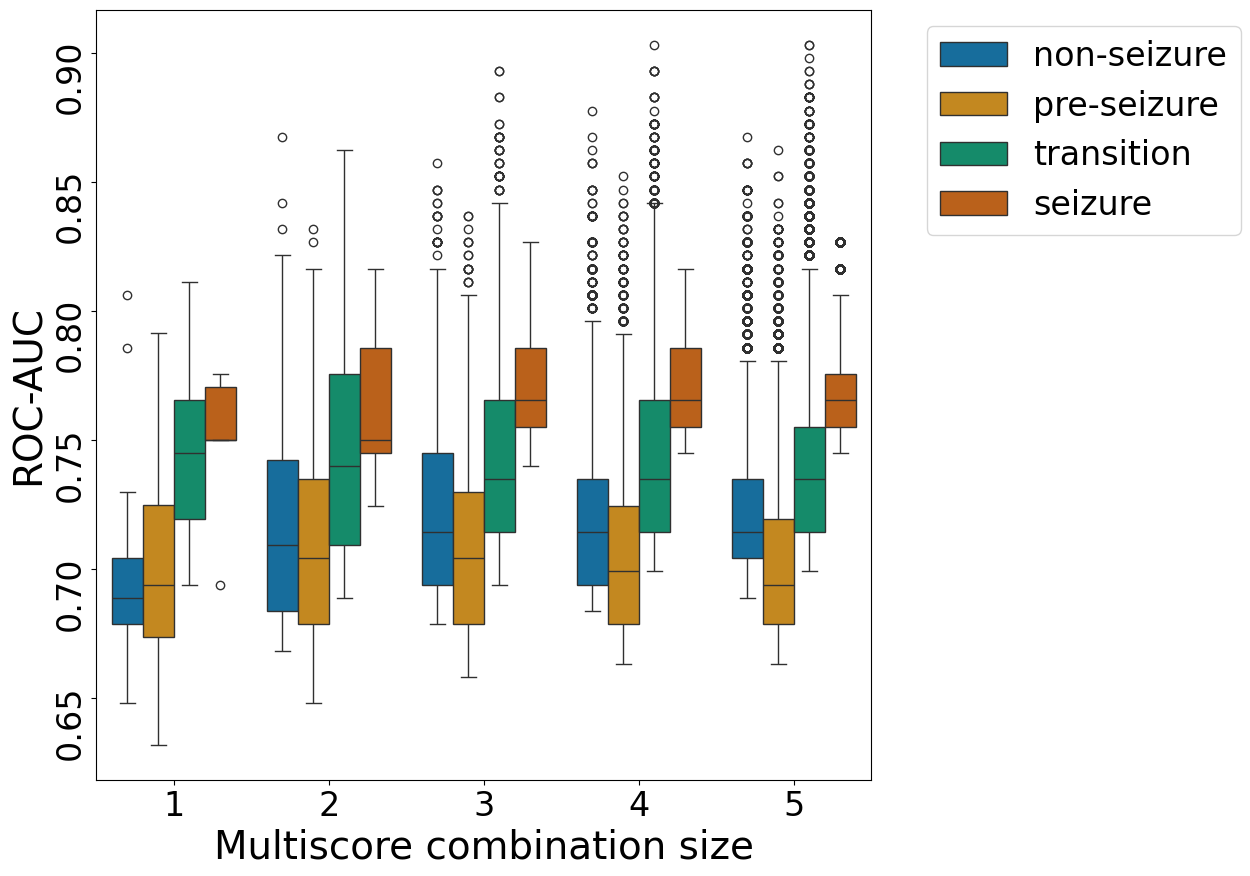

In [ ]:
plt.figure(figsize=(10,10))
# bp=sns.boxplot(y="overlap", x="tick", data=data, palette="colorblind", width=0.5)
bp=sns.boxplot(y="yd", x="xd", data=datasorted, hue="hue_woi", palette="colorblind")

handles, labels = bp.get_legend_handles_labels()
plt.legend(handles[0:len(wois)], labels[0:len(wois)], fontsize=24,bbox_to_anchor=(1.05, 1))
# plt.title("Network overlap", size=24)
plt.yticks(fontsize=24,rotation=90)
plt.xticks(fontsize=24)
plt.ylabel('ROC-AUC',fontsize=28)
plt.xlabel('Multiscore combination size',fontsize=28)

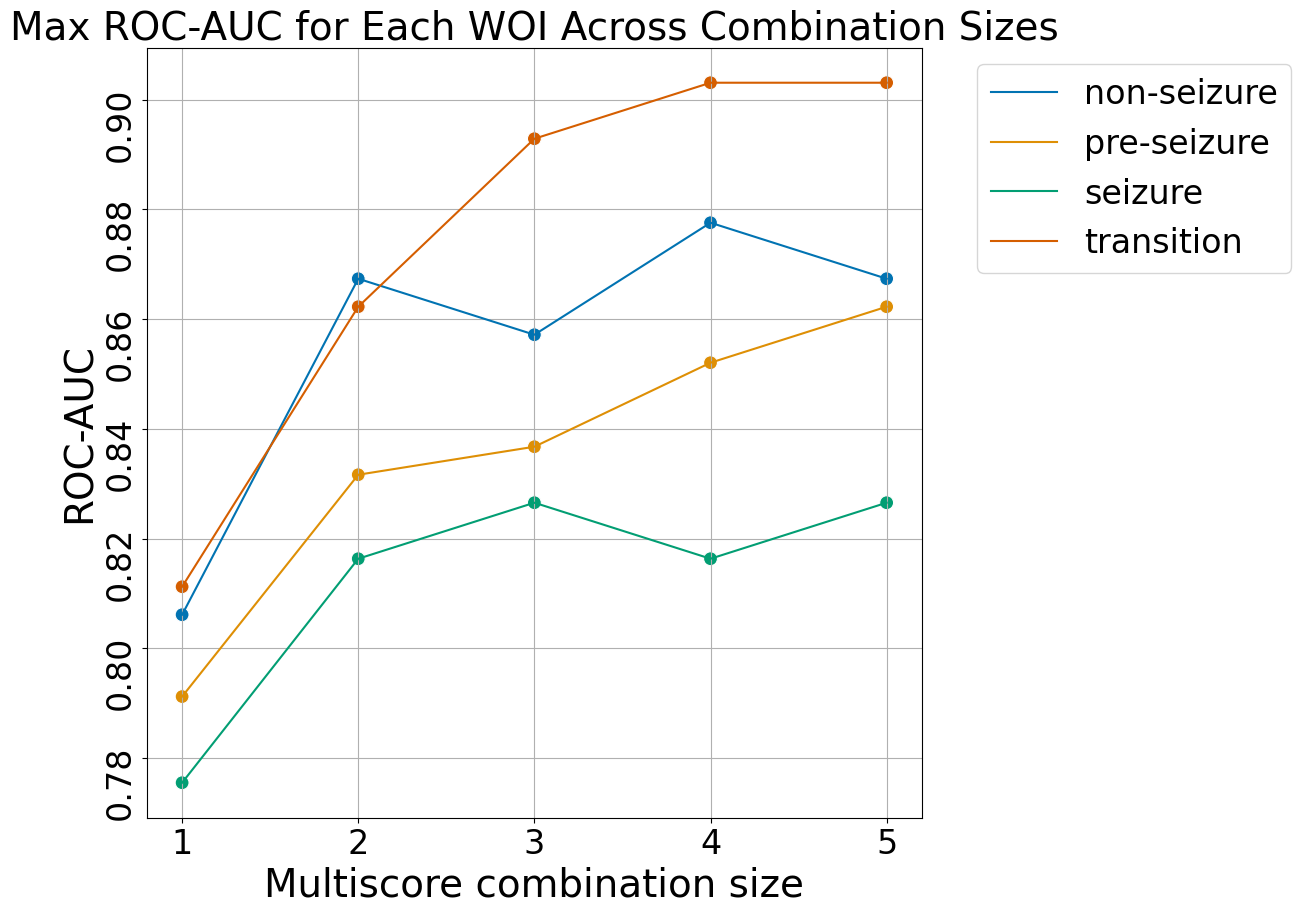

In [ ]:
df_datasorted = pd.DataFrame(datasorted)

# Find the max AUC for each WOI and combination size
max_auc_df = df_datasorted.groupby(['xd', 'hue_woi']).max().reset_index()

# Plotting
plt.figure(figsize=(10, 10))

# Scatter plot
bp = sns.scatterplot(y="yd", x="xd", data=max_auc_df, hue="hue_woi", palette="colorblind", s=100, legend=False)

# Line plot
bp = sns.lineplot(y="yd", x="xd", data=max_auc_df, hue="hue_woi", palette="colorblind", markers=True, dashes=False)

handles, labels = bp.get_legend_handles_labels()
plt.legend(handles[0:len(wois)], labels[0:len(wois)], fontsize=24,bbox_to_anchor=(1.05, 1))

# plt.title("Network overlap", size=24)
plt.yticks(fontsize=24,rotation=90)
plt.xticks(fontsize=24)
plt.xlabel('Multiscore combination size',fontsize=28)
plt.ylabel('ROC-AUC',fontsize=28)
plt.title('Max ROC-AUC for Each WOI Across Combination Sizes', fontsize=28)
plt.grid(True)
plt.show()

 Identify and save the combination that gives highest ROC-AUC for each WOI:


In [ ]:
wois=["NN","N60S","NS","NE"]


# Initialize lists to store the highest ROC-AUC combination data for each WOI
highest_combinations = {}
above_avg_rocauc = {}

# Iterate through each combination size
for it in range(1, 6):
    f = "{}cm_rocauc_results.xlsx".format(it)
    df = pd.read_excel(main_folder + f)

    for woi in wois:
        df_woi = df[df['WOI'] == woi]

        # Find the combination with the highest ROC-AUC
        max_auc = df_woi['AUC'].max()
        best_combination = df_woi[df_woi['AUC'] == max_auc]

        # Save the best combination and above-average ROC-AUC values
        if woi not in highest_combinations or max_auc > highest_combinations[woi]['AUC']:
            highest_combinations[woi] = best_combination.iloc[0].to_dict()
            above_avg_rocauc[woi] = df_woi[df_woi['AUC'] >= df_woi['AUC'].mean()]

# Create a new DataFrame to store the above-average ROC-AUC values for each WOI
plot_data = pd.DataFrame(columns=['WOI', 'AUC'])
for woi in wois:
    plot_data = pd.concat([plot_data, above_avg_rocauc[woi][['WOI', 'AUC']]])

# Reset index for the plot data
plot_data.reset_index(drop=True, inplace=True)

# Add human-readable WOI names
plot_data['WOI'] = plot_data['WOI'].replace({
    'NS': 'Transition',
    'N60S': 'Pre-seizure',
    'NE': 'Seizure',
    'NN': 'Non-seizure'
})


Line plot for the mean ROC-AUC, show standard deviation and overall max value as an asterix.

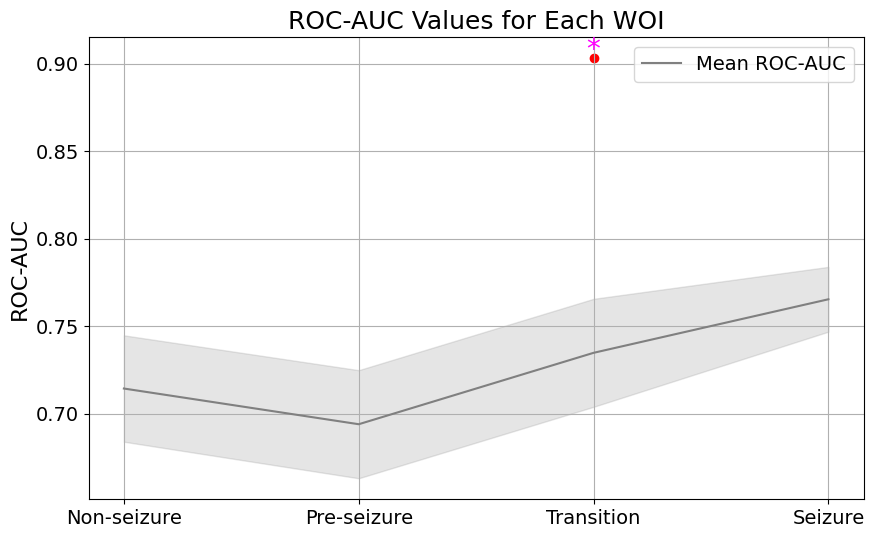

In [ ]:
# Ensure the WOI column is a categorical type with the correct order
plot_data['WOI'] = pd.Categorical(plot_data['WOI'], categories=['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure'], ordered=True)

# Plotting the line plot with standard deviation shadow
plt.figure(figsize=(10, 6))

# Plot the mean ROC-AUC for each WOI
mean_rocauc = plot_data.groupby('WOI')['AUC'].median()
std_rocauc = plot_data.groupby('WOI')['AUC'].std()
max_rocauc = plot_data.groupby('WOI')['AUC'].max()
min_rocauc = plot_data.groupby('WOI')['AUC'].min()

wois_ordered = ['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure']

# Use seaborn to ensure categorical order is respected
sns.lineplot(x=mean_rocauc.index, y=mean_rocauc, color='gray', label='Mean ROC-AUC')
plt.fill_between(mean_rocauc.index, min_rocauc, max_rocauc, color='gray', alpha=0.2)

# Mark the overall maximum ROC-AUC value with an asterisk
max_rocauc_value = plot_data['AUC'].max()
max_rocauc_woi = plot_data.loc[plot_data['AUC'].idxmax(), 'WOI']

# Mark the maximum ROC-AUC value for each WOI with an asterisk
for woi in plot_data['WOI'].unique():
  if woi != "Transition":
    max_woi_value = plot_data[plot_data['WOI'] == woi]['AUC'].max()
    plt.scatter([woi], [max_woi_value], color='gray', zorder=5)
    plt.text(woi, max_woi_value, '*', fontsize=15, color='gray', ha='center', zorder=5)

plt.scatter([max_rocauc_woi], [max_rocauc_value], color='magenta', zorder=10)
plt.text(max_rocauc_woi, max_rocauc_value, '*', fontsize=20, color='magenta', ha='center', zorder=5)

# Customize the plot
plt.ylabel('ROC-AUC', fontsize=22)
plt.xlabel('')
plt.title('Top 1% ROC-AUC Values for Each WOI', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()


Now visualize the mean, min-to-max range, and the max ROC-AUC values for the top 1% of ROC-AUC values. This way we focus on the connectivity measure combinations that are informative to identify the epileptogenic network and predict the surgical outcomes.  

In [ ]:
wois = ["NN", "N60S", "NS", "NE"]

# Initialize lists to store the highest ROC-AUC combination data for each WOI
highest_combinations = {}
top_1_percent_rocauc = {}

# Iterate through each combination size
for it in range(1, 6):
    f = "{}cm_rocauc_results.xlsx".format(it)
    df = pd.read_excel(main_folder + f)

    for woi in wois:
        df_woi = df[df['WOI'] == woi]

        # Find the combination with the highest ROC-AUC
        max_auc = df_woi['AUC'].max()
        best_combination = df_woi[df_woi['AUC'] == max_auc]

        # Save the best combination and top 1% ROC-AUC values
        if woi not in highest_combinations or max_auc > highest_combinations[woi]['AUC']:
            highest_combinations[woi] = best_combination.iloc[0].to_dict()

        # Calculate the 99th percentile
        auc_99th_percentile = df_woi['AUC'].quantile(0.99)
        top_1_percent_rocauc[woi] = df_woi[df_woi['AUC'] >= auc_99th_percentile]

# Create a new DataFrame to store the top 1% ROC-AUC values for each WOI
plot_data = pd.DataFrame(columns=['WOI', 'AUC'])
for woi in wois:
    plot_data = pd.concat([plot_data, top_1_percent_rocauc[woi][['WOI', 'AUC']]])

# Reset index for the plot data
plot_data.reset_index(drop=True, inplace=True)

# Add human-readable WOI names
plot_data['WOI'] = plot_data['WOI'].replace({
    'NS': 'Transition',
    'N60S': 'Pre-seizure',
    'NE': 'Seizure',
    'NN': 'Non-seizure'
})


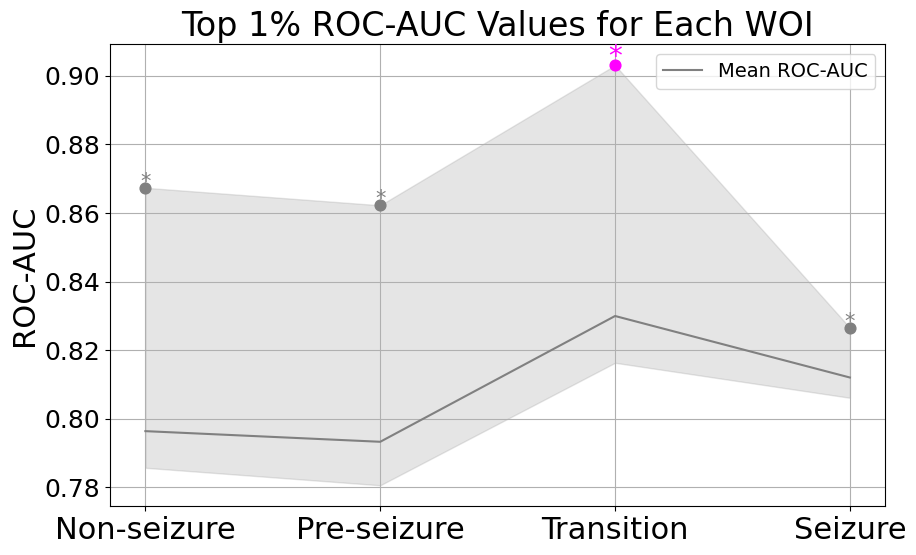

In [ ]:
# Ensure the WOI column is a categorical type with the correct order
plot_data['WOI'] = pd.Categorical(plot_data['WOI'], categories=['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure'], ordered=True)

# Plotting the line plot with standard deviation shadow
plt.figure(figsize=(10, 6))

# Plot the mean ROC-AUC for each WOI
mean_rocauc = plot_data.groupby('WOI')['AUC'].mean()
std_rocauc = plot_data.groupby('WOI')['AUC'].std()
max_rocauc = plot_data.groupby('WOI')['AUC'].max()
min_rocauc = plot_data.groupby('WOI')['AUC'].min()

# Use seaborn to ensure categorical order is respected
sns.lineplot(x=mean_rocauc.index, y=mean_rocauc, color='gray', label='Mean ROC-AUC')
plt.fill_between(mean_rocauc.index, min_rocauc, max_rocauc, color='gray', alpha=0.2)

# Mark the overall maximum ROC-AUC value with an asterisk
max_rocauc_value = plot_data['AUC'].max()
max_rocauc_woi = plot_data.loc[plot_data['AUC'].idxmax(), 'WOI']

# Mark the maximum ROC-AUC value for each WOI with an asterisk
for woi in plot_data['WOI'].unique():
  if woi != "Transition":
    max_woi_value = plot_data[plot_data['WOI'] == woi]['AUC'].max()
    plt.scatter([woi], [max_woi_value], color='gray', zorder=5, s=60)
    plt.text(woi, max_woi_value, '*', fontsize=15, color='gray', ha='center', zorder=5)

plt.scatter([max_rocauc_woi], [max_rocauc_value], color='magenta', zorder=5, s=60)
plt.text(max_rocauc_woi, max_rocauc_value, '*', fontsize=20, color='magenta', ha='center', zorder=5)

# Customize the plot
plt.ylabel('ROC-AUC', fontsize=22)
plt.xlabel('')
plt.title('Top 1% ROC-AUC Values for Each WOI', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()


Now plot ROC-AUC values that are above mean + 3*std.

---



---



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store the highest ROC-AUC combination data for each WOI
highest_combinations = {}
top_rocauc_values = {}

# Iterate through each combination size
for it in range(1, 6):
    f = "{}cm_rocauc_results.xlsx".format(it)
    df = pd.read_excel(main_folder + f)

    for woi in wois:
        df_woi = df[df['WOI'] == woi]

        # Find the combination with the highest ROC-AUC
        max_auc = df_woi['AUC'].max()
        best_combination = df_woi[df_woi['AUC'] == max_auc]

        # Save the best combination and top 1% ROC-AUC values
        if woi not in highest_combinations or max_auc > highest_combinations[woi]['AUC']:
            highest_combinations[woi] = best_combination.iloc[0].to_dict()
            threshold = df_woi['AUC'].mean() + 3 * df_woi['AUC'].std()
            top_rocauc_values[woi] = df_woi[df_woi['AUC'] >= threshold]

# Create a new DataFrame to store the top 1% ROC-AUC values for each WOI
plot_data = pd.DataFrame(columns=['WOI', 'AUC'])
for woi in wois:
    plot_data = pd.concat([plot_data, top_rocauc_values[woi][['WOI', 'AUC']]])

# Reset index for the plot data
plot_data.reset_index(drop=True, inplace=True)

# Add human-readable WOI names
plot_data['WOI'] = plot_data['WOI'].replace({
    'NS': 'Transition',
    'N60S': 'Pre-seizure',
    'NE': 'Seizure',
    'NN': 'Non-seizure'
})

# Ensure the WOI column is a categorical type with the correct order
plot_data['WOI'] = pd.Categorical(plot_data['WOI'], categories=['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure'], ordered=True)


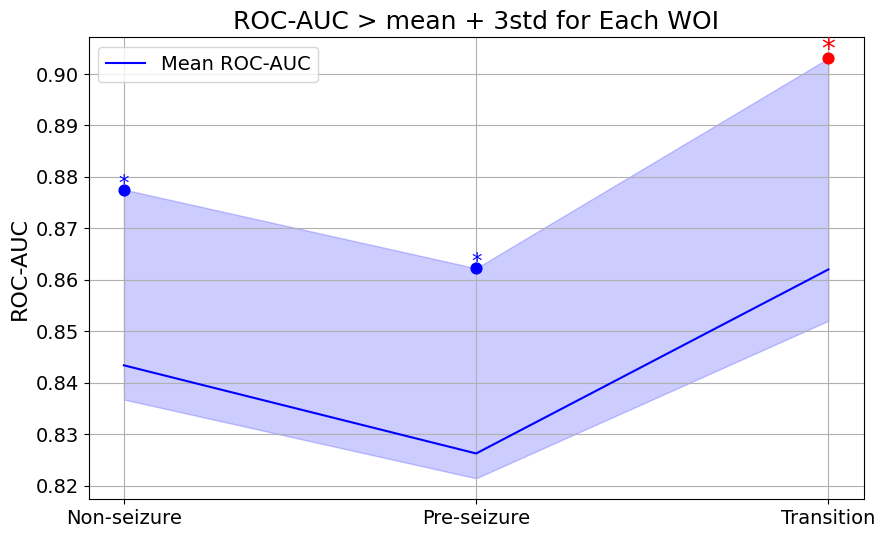

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the WOI column is a categorical type with the correct order
plot_data['WOI'] = pd.Categorical(plot_data['WOI'], categories=['Non-seizure', 'Pre-seizure', 'Transition', 'Seizure'], ordered=True)

# Plotting the line plot with standard deviation shadow
plt.figure(figsize=(10, 6))

# Plot the mean ROC-AUC for each WOI
mean_rocauc = plot_data.groupby('WOI')['AUC'].mean()
std_rocauc = plot_data.groupby('WOI')['AUC'].std()
max_rocauc = plot_data.groupby('WOI')['AUC'].max()
min_rocauc = plot_data.groupby('WOI')['AUC'].min()

# Use seaborn to ensure categorical order is respected
sns.lineplot(x=mean_rocauc.index, y=mean_rocauc, color='blue', label='Mean ROC-AUC')
plt.fill_between(mean_rocauc.index, min_rocauc, max_rocauc, color='blue', alpha=0.2)

# Mark the overall maximum ROC-AUC value with an asterisk
max_rocauc_value = plot_data['AUC'].max()
max_rocauc_woi = plot_data.loc[plot_data['AUC'].idxmax(), 'WOI']

# Mark the maximum ROC-AUC value for each WOI with an asterisk
for woi in plot_data['WOI'].unique():
  if woi != "Transition":
    max_woi_value = plot_data[plot_data['WOI'] == woi]['AUC'].max()
    plt.scatter([woi], [max_woi_value], color='blue', zorder=5, s=60)
    plt.text(woi, max_woi_value, '*', fontsize=15, color='blue', ha='center', zorder=5)

plt.scatter([max_rocauc_woi], [max_rocauc_value], color='red', zorder=5, s=60)
plt.text(max_rocauc_woi, max_rocauc_value, '*', fontsize=20, color='red', ha='center', zorder=5)

# Customize the plot
plt.ylabel('ROC-AUC', fontsize=16)
plt.xlabel('')
plt.title('ROC-AUC > mean + 3std for Each WOI', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()
